### Import stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from scipy import optimize
import time
from tqdm import tqdm
from saxs import ScatterData
from methods import *

# Load data

## Load diff data from EuXFEL

In [2]:
# Path where XFEL data is 
XFEL_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data'

# Get the time points of the the data, as well as time resolved data
time_points = np.array([float(file.replace('us_averaged.npy','')) for file in os.listdir(XFEL_path) if 'us' in file])
XFEL_tr = np.array([os.path.join(XFEL_path,file) for file in os.listdir(XFEL_path) if 'us' in file])

# Sort from slowest timpoints to the fastest timepoints. 
sort_ind = np.argsort(time_points)[::-1]
time_points = time_points[sort_ind]
XFEL_tr = XFEL_tr[sort_ind]

# Keep ScatterData in list for easy access 
XFEL_empty = [ScatterData() for i in range(XFEL_tr.shape[0])]
# Load q vector from XFEL 
XFEL_q = np.load(f'/home/leonardo/SAXS_222711/data_csv/Hamburg_data/q.npy')

# Iterate over time resolved data and set I and q for ScatterData
XFEL_data = []
for data,i in zip(XFEL_empty, XFEL_tr):
    intensity = np.load(i)
    data.set_data(XFEL_q,intensity)
    XFEL_data.append(data)
print(time_points)

[269.51 223.41 180.85 136.53  92.2   47.88   3.55]


## Load SAXS data - Measurement 1, FEB 2023

In [3]:
#Load data from Diamond 20C 15mg/ml
dark_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Dark_sub/csv'
light_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Light_sub/csv'

# Get the data from files and creates ScatterData object that are stored in lists
dark_files = np.array([os.path.join(dark_path,file) for file in os.listdir(dark_path)])
light_files = np.array([os.path.join(light_path,file) for file in os.listdir(light_path)])
time__steady = [10,10,20,20]

SAXS_dark_steady = []
SAXS_light_steady = []
SAXS_diff_steady = []
                       
for light, dark in zip(light_files,dark_files):
    dark = ScatterData(dark)
    light = ScatterData(light)
    diff_SAXS = calc_diff(light,dark)
    SAXS_dark_steady.append(dark)
    SAXS_light_steady.append(light)
    SAXS_diff_steady.append(diff_SAXS)
    


## Load SAXS data - Measurement 2, FEB 2023

In [4]:
#Load data from Diamond 20C 15mg/ml
dark_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv'
light_path = '/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv'

dark_files = np.array([os.path.join(dark_path,file) for file in os.listdir(dark_path)])
light_files = np.array([os.path.join(light_path,file) for file in os.listdir(light_path)])
time_illumination = [1,2,10,20]
SAXS_dark_illumination = []
SAXS_light_illumination = []
SAXS_diff_illumination = []
                       
for light, dark in zip(light_files,dark_files):
    dark = ScatterData(dark)
    light = ScatterData(light)
    diff_SAXS = calc_diff(light,dark)
    SAXS_dark_illumination.append(dark)
    SAXS_light_illumination.append(light)
    SAXS_diff_illumination.append(diff_SAXS)
    


## Load temperature experiment SAXS Nov 22

In [5]:
temp_saxs_path = '/home/leonardo/SAXS_222711/data_csv/temperature_exp'
temperatures = np.array([int(file.replace('AsLOV2_15mgml_','').replace('C_average_average.dat.csv','')) for file in os.listdir(temp_saxs_path)])
temp_saxs = np.array([os.path.join(temp_saxs_path,file) for file in os.listdir(temp_saxs_path)])

# Sort temperature from highest to lowest as well as the data files
sort_ind = np.argsort(temperatures)[::-1]
temperatures = temperatures[sort_ind]
temp_saxs = temp_saxs[sort_ind]
SAXS_temp = [ScatterData(file) for file in temp_saxs]

## Load light data from XFEL

In [6]:
#Load Dark and Light data from XFEL
dark_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Dark'
light_path = '/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Light'

dark_files = np.array([os.path.join(dark_path,file) for file in os.listdir(dark_path)])
light_files = np.array([os.path.join(light_path,file) for file in os.listdir(light_path)])

buffer_dark = np.load('/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Buffer_off_runr0133.npy')
buffer_light =np.load('/home/leonardo/SAXS_222711/data_csv/Hamburg_data/Buffer_on_runr0133.npy')

buffer_light = np.nansum(buffer_light[150:175,:],axis = 0)/25
buffer_dark =np.nansum(buffer_dark[150:175,:],axis = 0)/25

darks = np.zeros((5,176,XFEL_q.shape[0]))
lights = np.zeros((5,176,XFEL_q.shape[0]))

for i,states in enumerate(zip(dark_files, light_files)):
    dark,light = states
    d = np.load(dark)
    l = np.load(light)
    darks[i] = d[:176]
    lights[i] = l[:176]

dark = (np.sum(darks,axis=0))/len(dark_files)
dark = np.sum(dark[150:175,:],axis = 0)/25

light = (np.sum(lights,axis=0))/len(light_files)
light = np.sum(light[150:175,:],axis = 0)/25

# Factor of 0.935 for buffer subtraction matching the SAXS baseline 
XFEL_dark = buffer_sub(dark, buffer_dark,XFEL_q,.935)
XFEL_light= buffer_sub(light, buffer_light,XFEL_q,.935)




## Plot data for verification

### Plot buffer subtracted data

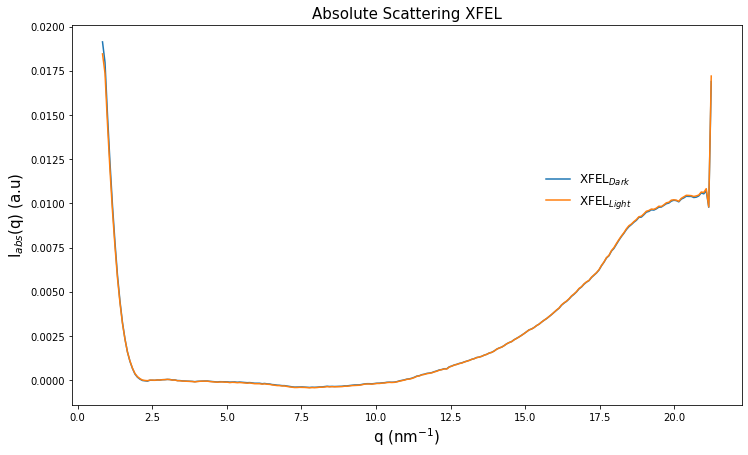

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(XFEL_dark.q,XFEL_dark.i, label=r'XFEL$_{Dark}$')
ax.plot(XFEL_light.q,XFEL_light.i, label=r'XFEL$_{Light}$')
ax.legend(loc=(0.7, 0.5), frameon=False, fontsize=12)
ax.set_title('Absolute Scattering XFEL', fontsize=15)
ax.set_ylabel(r'I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
plt.show()




### Plot Diff data XFEL

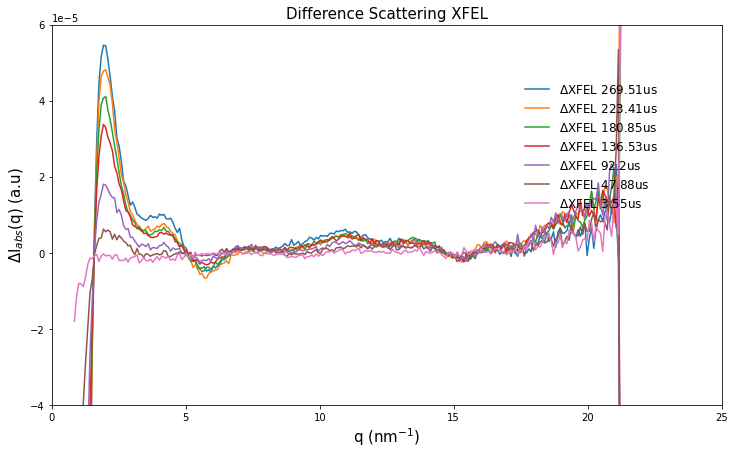

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , time in zip(XFEL_data, time_points):
    ax.plot(data.q,data.i, label=r'$\Delta$XFEL '+str(time)+'us')
ax.legend(loc=(0.7, 0.5), frameon=False, fontsize=12)
ax.set_title('Difference Scattering XFEL', fontsize=15)
ax.set_ylabel(r'$\Delta$I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.set_ylim([-4e-5,6e-5])
ax.set_xlim([data.q[0],25])
plt.show()


# Temperature differences

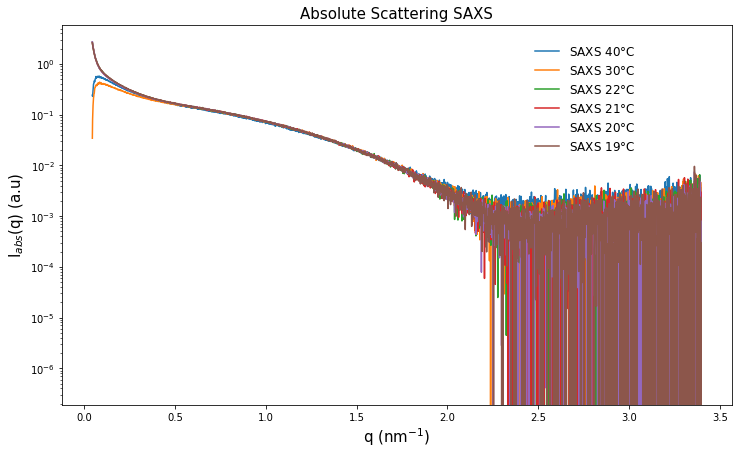

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , temp in zip(SAXS_temp, temperatures):
    ax.plot(data.q*10,data.i, label=r'SAXS '+str(temp)+r'$\degree$C')
ax.legend(loc=(0.7, 0.65), frameon=False, fontsize=12)
ax.set_title('Absolute Scattering SAXS', fontsize=15)
ax.set_ylabel(r'I$_{abs}$(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.set_yscale('log')

plt.show()

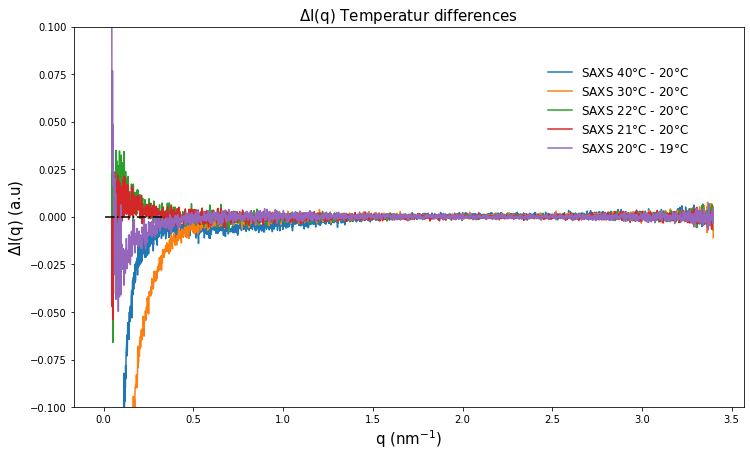

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
for data , temp in zip(SAXS_temp, temperatures):
    if data == SAXS_temp[4]:
        continue
    if data == SAXS_temp[-1]:
        ax.plot(data.q*10,SAXS_temp[4].i-data.i, label=r'SAXS '+str(temperatures[4])+r'$\degree$C - '+str(temp)+r'$\degree$C')
    else:
        ax.plot(data.q*10,data.i-SAXS_temp[4].i, label=r'SAXS '+str(temp)+r'$\degree$C - '+str(temperatures[4])+r'$\degree$C')
ax.legend(loc=(0.7, 0.65), frameon=False, fontsize=12)
ax.set_title('$\Delta$I(q) Temperatur differences', fontsize=15)
ax.set_ylabel(r'$\Delta$I(q) (a.u)', fontsize=15)
ax.set_xlabel(r'q (nm$^{-1}$)', fontsize=15)
ax.hlines(0, xmin = data.q[0], xmax = 0.34, color='k', linestyle='-.')
ax.set_ylim([-.1,.1])

plt.show()

# AlphaFold2 Models


## AF2 load data

In [123]:
AF2_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities/fixed'
names = [ScatterData(file) for file in files]
names.sort()
files = np.array([os.path.join(AF2_path,file) for file in os.listdir(AF2_path)])
ind = np.argsort(files)
AF2_data = np.array([ScatterData(file) for file in files])
AF2_data = AF2_data[ind]



## Main function for calculating various metrics

In [ ]:
def calc_metrics(q_min,q_max,k,n): 
    # Adjust exp. difference data to q-range 
    exp_diff_cut = XFEL_data[0].cut_q(q_min,q_max)
    exp_diff_cut = exp_diff_cut.remove_nan()

    exp_dark_cut = XFEL_dark.cut_q(q_min,q_max)
    exp_dark_cut = exp_dark_cut.remove_nan()
    
    theory_ref = AF2_data[0].scale_q(10)
    theory_ref= theory_ref.cut_q(q_min,q_max)
    
    # Interpolate exp. difference data
    exp_diff_interpolated = interpolate(theory_ref.q,exp_diff_cut)
    exp_diff_interpolated_scaled_I = exp_diff_interpolated.scale_intensity(1e5)
    exp_diff_interpolated_scaled_cc = exp_diff_interpolated.scale_intensity(1/exp_diff_interpolated.q)
    
    # Interpolate exp. absolute data
    exp_abs_interpolated = interpolate(theory_ref.q,XFEL_dark)
    exp_abs_interpolated_scaled_I = exp_abs_interpolated.scale_intensity(1e5)
    #Define list with metrics
    corr_final = []
    R2 = []
    fopts = []
    file1_index = []
    file2_index = []
    occupancies = []
    
    print(f'Running {2000-n} models')
    # Iterate over each model in the list of models
    for model1 in tqdm(AF2_data[n:]):
        # Iterate over the models after current model to calculate half difference matrix
        for model2 in AF2_data[names.index(model1):]:    
            if model1 == model2:
                continue
            
            # Scale the data with 1/q to maximize the small q region 
            theory_diff = calc_diff(model1, model2)
            theory_diff = theory_diff.scale_q(10)
            theory_diff = theory_diff.cut_q(q_min,q_max)
            theory_scaled_cc = theory_diff.scale_intensity(1/theory_diff.q)
            #print(theory_scaled_cc.i/theory_diff.q)
            
            # Scale exp. diff and exp. abs to theory (factor of 1*e5 for faster calc.)
            scale_diff,fopt_diff = SSE(exp_diff_interpolated_scaled_I.i,theory_diff.i, 0.0002)
            
            # To find which model is dark and light 
            if scale_diff > 0:
                model1_adjusted = model1.scale_q(10)
                model1_adjusted = model1_adjusted.cut_q(q_min,q_max)
                scale_abs,fopt_abs = SSE(exp_abs_interpolated_scaled_I.i, model1_adjusted.i, 0.0002)
            else:
                model2_adjusted = model2.scale_q(10)
                model2_adjusted = model2_adjusted.cut_q(q_min,q_max)
                scale_abs,fopt_abs = SSE(exp_abs_interpolated_scaled_I.i, model2_adjusted.i, 0.0002)
                
            
            # Calculate the R2 between intepolated experimental curve and the theoretical curve
            r2= calc_r2(exp_diff_interpolated.i, theory_diff.i*scale_diff)
            # Calc Pearson CC
            corr = np.corrcoef(exp_diff_interpolated_scaled_cc.i,theory_diff.i, rowvar=True)[0][1]            
            # Calc occupance
            occupancy = (scale_diff/scale_abs)[0]
 
            
            file1_index.append(AF2_data.index(model1))
            file2_index.append(AF2_data.index(model2))
            corr_final.append(corr)
            R2.append(r2)
            fopts.append(fopt_diff/scale_diff[0])
            occupancies.append(occupancy)
        
    print(corr_final)
    np.save(f'/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/occupancy', occupancies)
    np.save(f'/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/correlations',corr_final)
    np.save(f'/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/R2',R2)
    np.save(f'/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/fopts',fopts)
    np.save(f'/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/model1_index',file1_index)
    np.save(f'/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/model2_index',file2_index)
    
    fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(theory_diff.q, theory_diff.i, linewidth=3.0,label='Theory', marker='o')
    ax.plot(exp_diff_interpolated_scaled_I.q, exp_diff_interpolated_scaled_I.i/scale_diff, linewidth=2.0,label='XFEL_interpolated')
    ax.plot(XFEL_data[0].q, XFEL_data[0].i, linewidth=2.0,label='XFEL_raw')
    #ax.plot(exp_diff_interpolated.q, exp_diff_interpolated.i, linewidth=2.0,label='XFEL')
    
    
    
    #ax.set_title('$\Delta$I(q)',fontsize=15)
    #ax.set_ylabel('Intensity (a.u.)',fontsize=15)
    #ax.set_ylim([-.00001,.000065])
    #ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    ax.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/XFEL_Vs_interpolated',bbox_inches='tight',facecolor=(1, 1, 1))
    
    #fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    #ax.plot(theory_q, dark[crysol_i], linewidth=3.0,label=f'corr: {round(abs(corr),3)} \n r²:{round(r2,3)}', marker='o')
    #ax.plot(theory_q, interpolated_abs/scale_diff*1e5, linewidth=5.0,label='Interpolated XFEL', marker='o')
    #ax.set_yscale('log')



## Run Main


In [ ]:
import time
start=time.time()
k=0
n=1900
q_max = 20
q_min = np.nanmin(XFEL_data[0].q[10])
calc_metrics(q_min,q_max,k,n)
end_time=time.time()
ex_time=round(end_time-start,3)
print(f'Run time: {ex_time} seconds for {2000-n} models')


Running 100 models


  0%|                                                   | 0/100 [00:00<?, ?it/s]


ValueError: <saxs.ScatterData object at 0x7f677b353c10> is not in list

In [122]:
print(np.load('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/new_note_book/R2.npy'))

## Main function for plotting data

### Func

In [864]:
#Changed to get path, this version only for subset of data (250 models).
def get_data_array(path, start, end):
    files = [os.path.join(path,file) for file in os.listdir(path)]
    files.sort()
    nested_array  = np.zeros((len(files)),dtype=object)
    
    flatten_array = np.empty((0))
    for i,file in enumerate(files):
            data  = np.load(file)
            nested_array[i] = data
            flatten_array = np.concatenate((flatten_array,data))
    return nested_array, flatten_array


def get_rg_diff(indices_light,indices_dark,rg): 
    rg_diff= []
    for m1,m2 in zip(indices_light,indices_dark):
        diff = rg[m1] - rg[m2]
        rg_diff.append(diff)
    return rg_diff

def plotter(indices,model1,model2,theory_q,exp_interpolated,ax):
    indices_dark = []
    indices_light = []
    for index in indices:  
        m1 = model1[index]
        m2 = model2[index]
        diff = get_diff(q_min,q_max,m1,m2)
        diff_scaled = diff * 1/theory_q
        k,f = SSE(diff,exp_interpolated,1) 
        if index == indices[-1]:
            ax.plot(theory_q, (diff_scaled/k), linewidth=0.5, color='Blue',label = 'Theoretical diff. signal') 
        else:
            ax.plot(theory_q, (diff_scaled/k), linewidth=0.5, color='Blue') 
        
        if k > 0:
            indices_light.append(m1)
            indices_dark.append(m2)
        
        else:
            indices_light.append(m2)
            indices_dark.append(m1)
    return indices_light,indices_dark

def plot_top(start,end,qmax,qmin,x):
    names = os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')
    names.sort()
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')]
    files.sort()
    
    # Adjust Theoretical q
    crysol_q = np.loadtxt(files[0], usecols=1, delimiter=',')*10
    theory_q,crysol_i = cut_q(crysol_q,q_max,q_min)
    
    # Adjust XFEL q and data 
    h1_af2 = h1[10:255]
    h1_q = hamburg_q[10:255]
    xfel_q,xfel_i = cut_q(h1_q,q_max,q_min)
    xfel_cut = h1_af2[xfel_i]
                                                            
    #Data paths
    R2_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/R2.npy'
    corr_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/correlations.npy'
    fopt_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/fopts.npy'
    model1_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/file1_index.npy'
    model2_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/file2_index.npy'
    rg_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/rgs.npy'
    occupancy = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/occupancy.npy'
                                                                   
    #Initiate plot
    fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    #Interpolate XFEL data and scale
    exp_interpolated = interpolate_curve(theory_q,xfel_q,xfel_cut)
    exp_scaled = exp_interpolated * theory_q

                                                            
    # Start retrieving data                                    
    R2 = np.load(R2_path)
    fopt = np.load(fopt_path)
    corr = np.load(corr_path)
    model1 =np.load(model1_path)
    model2 =np.load(model2_path)
    rg = np.load(rg_path)
    occupancy = np.load(occupancy)

    # Order data according to metric
    best_indices = R2.argsort()[-x-1:]
    #best_indices = corr.argsort()[:x+1]
    
     
    
        
    # Loop over best models and plot    
    indices_light, indices_dark = plotter(best_indices,model1,model2, theory_q, exp_interpolated,ax)
    #rg_diff = np.array(get_rg_diff(indices_light,indices_dark,rg))

    # Save all unique models 
    #np.save('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/light_indices_unique',np.unique(indices_light))
    #np.save('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/dark_indices_unique',np.unique(indices_dark))
    # Save all pair of models
    #np.save('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/light_indices',indices_light)
    #np.save('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/dark_indices',indices_dark)   
            
    # XFEL Plot
    ax.plot(theory_q, exp_interpolated, linewidth=6.0, color='Red', label='Exp.diff singnal')
    #ax.set_ylim([-4e-5,6e-5])
    ax.set_title(f' Top {x} difference models based on best R²', fontsize=15)
    ax.set_ylabel(f'Intensity(a.u)',fontsize=15)
    ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    ax.legend(loc=(0.5,0.1), frameon = True,fontsize=15)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Top_{x}_models(based_on_R²).png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    # Plot R² 
    fig7, ax7= plt.subplots(1, 1, figsize=(12, 7))
    ax7.set_title('R² distribution', fontsize=16)
    ax7.set_xlabel('R²',fontsize=13)
    ax7.set_ylabel('Number of models', fontsize=13)
    plot =plt.hist(R2, bins=50)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histo_R2.png',bbox_inches='tight',facecolor=(1, 1, 1))
   
    
    # Plot Occupancy 
    fig8, ax8 = plt.subplots(1, 1, figsize=(12, 7))
    ax8.set_title('Activation ratio distribution', fontsize=16)
    ax8.set_xlabel('Activation ratios', fontsize=13)
    ax8.set_ylabel('Number of models', fontsize=13)
    plot =plt.hist(abs(occupancy), bins=50)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histo_occupancy_full.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    # Plot occupancy Vs. R²
    fig9, ax9 = plt.subplots(1, 1, figsize=(12, 7))
    #ax9.scatter(R2[abs(occupancy)<1],abs(occupancy[abs(occupancy)<1]))
    ax9.scatter(R2,abs(occupancy))
    ax9.set_title(f' Activation ratio < 1 Vs. R²', fontsize=15)
    ax9.set_ylabel(f'Activation ratio',fontsize=15)
    ax9.set_xlabel('R²',fontsize=15)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Occupancy_R2.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    best_occupancy = np.logical_and(abs(occupancy)<0.2, R2>0)
    #print(np.where(best_occupancy==True)[0].shape)
    
    fig11, ax11 = plt.subplots(1, 1, figsize=(12, 7))
    ax11.set_ylim([-4e-5,6e-5])
    ax11.set_title(f' Top difference models with R² > 0.2 and Activation ratio < 1)', fontsize=15)
    ax11.set_ylabel(f'Intensity(a.u)',fontsize=15)
    ax11.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    indices_light, indices_dark = plotter(np.where(best_occupancy==True)[0],model1,model2, theory_q, exp_interpolated,ax11)
    ax11.plot(theory_q, exp_interpolated, linewidth=6.0, color='Red')
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/best_models_occupancy+r2.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    #fig11, ax11 = plt.subplots(1, 1, figsize=(12, 7))
    #best_occupancy = np.logical_and(abs(occupancy)<1.0, abs(corr)>.8)
    #ax11.set_ylim([-4e-5,6e-5])
    #ax11.set_title(f' Top difference models with PCC > 0.8 and Occupancy < 1)', fontsize=15)
    #ax11.set_ylabel(f'Intensity(a.u)',fontsize=15)
    #ax11.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    #indices_light, indices_dark = plotter(np.where(best_occupancy==True)[0],model1,model2, theory_q, exp_interpolated,ax11)
    #ax11.plot(theory_q, exp_interpolated, linewidth=6.0, color='Red')
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/best_models_occupancy+PCC.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    indices = np.where(best_occupancy==True)
    rg_diff = np.array(get_rg_diff(model1[indices],model2[indices],rg))
    
    # Plot difference in Rg 
    fig7, ax7 = plt.subplots(1, 1, figsize=(12, 7))
    ax7.set_title(f'$\Delta$Rg Vs. R²')
    ax7.set_ylabel('R²')
    ax7.set_xlabel('$\Delta$Rg')
    ax7.scatter(rg_diff, R2[indices])
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/rg_diff_R2_best_occupancy.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    
     # Plot difference in Rg 
    fig7, ax7 = plt.subplots(1, 1, figsize=(12, 7))
    ax7.set_title(f'$\Delta$Rg Vs. Activation ratio')
    ax7.set_ylabel('Activation ratio')
    ax7.set_xlabel('$\Delta$Rg')
    ax7.scatter(rg_diff, occupancy[indices])
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/rg_diff_Vs_occupancy.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    
    rg_diff = np.array(get_rg_diff(model1,model2,rg))
     # Plot difference in Rg 
    fig7, ax7 = plt.subplots(1, 1, figsize=(12, 7))
    ax7.set_title(f'$\Delta$Rg Vs. R²')
    ax7.set_ylabel('R²')
    ax7.set_xlabel('$\Delta$Rg')
    ax7.scatter(rg_diff, R2)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/rg_diff_R2_all.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    
    fig7, ax7 = plt.subplots(1, 1, figsize=(12, 7))
    ax7.set_title(f'$\Delta$Rg Vs. Activation ratio')
    ax7.set_ylabel('Activation ratio')
    ax7.set_xlabel('$\Delta$Rg')
    ax7.scatter(rg_diff, abs(occupancy))
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/rg_diff_occupancy_all.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(f'$\Delta$Rg Vs. Activation ratio Vs. R2')
    ax.set_zlabel('Activation ratio')
    ax.set_xlabel('$\Delta$Rg')
    ax.set_ylabel('R²')
    ax.scatter(rg_diff[indices], R2[indices], abs(occupancy[indices]))
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/rg_diff_occupancy_R2_3D.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    """
    #Plot occurences of model
    
    indices_dark = np.array(indices_dark)
    indices_light = np.array(indices_light)
    
    dark_unique, dark_counts = np.unique(indices_dark, return_counts=True)
    dark_label = [str(i).replace('.0','') for i in dark_unique]
    fig3, ax3 = plt.subplots(1, 1, figsize=(20, 7))
    plt.bar(np.linspace(0,dark_unique.shape[0],num=dark_unique.shape[0]), dark_counts, tick_label=dark_label, width=0.4)
    plt.xticks(rotation = 90)
    ax3.set_title(f'Best AF2 dark model candidates from the top {x} difference models', fontsize=16)
    ax3.set_xlabel('Model number', fontsize=13)
    ax3.set_ylabel('Occurences' ,fontsize=13)
     
    
    light_unique, light_counts = np.unique(indices_light, return_counts=True)
    light_label = [str(i).replace('.0','') for i in light_unique]
    fig4, ax4 = plt.subplots(1, 1, figsize=(20, 7))
    plt.bar(np.linspace(0,light_unique.shape[0]*2,num=light_unique.shape[0]), light_counts, tick_label=light_label, width=0.4)
    plt.xticks(rotation = 90)
    ax4.set_title(f'Best AF2 light model candidates from the top {x} difference models', fontsize=16)
    ax4.set_xlabel('Model number', fontsize=13)
    ax4.set_ylabel('Occurences' ,fontsize=13)
    fig2, ax2 = plt.subplots(1, 1, figsize=(12, 7))
    ax2.set_title('fopt Vs. Pearson Correlation', fontsize=16)
    ax2.set_ylabel('Pearson Correlation', fontsize=13)
    ax2.set_xlabel('fopt', fontsize=13)
    plt.scatter(fopt,corr, norm=True)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histogram_CC.png',bbox_inches='tight',facecolor=(1, 1, 1))
    """
    """
    fig5, ax5 = plt.subplots(1, 1, figsize=(12, 7))
    ax5.set_title('fopt distribution', fontsize=16)
    ax5.set_xlabel('fopt', fontsize=13)
    ax5.set_ylabel('Number of models', fontsize=13)
    plot =plt.hist(fopt, bins=50)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histogram_fopt.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    # Plot Pearson CC 
    #fig6, ax6 = plt.subplots(1, 1, figsize=(12, 7))
    #ax6.set_title('Pearson CC distribution', fontsize=16)
    #ax6.set_xlabel('Pearson Correlation', fontsize=13)
    #ax6.set_ylabel('Number of models', fontsize=13)
    #plot =plt.hist(abs(corr), bins=50)
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histo_PCC.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    # Plot PCC Vs. R²
    #fig9, ax9 = plt.subplots(1, 1, figsize=(12, 7))
    #ax9.scatter(R2,abs(corr))
    #ax9.set_title(f' PCC Vs. R²)', fontsize=15)
    #ax9.set_ylabel(f'PCC',fontsize=15)
    #ax9.set_xlabel('R²',fontsize=15)
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/PCC_R2.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    # Plot occupancy Vs. Corr
    #fig9, ax9 = plt.subplots(1, 1, figsize=(12, 7))
    #ax9.scatter(abs(corr[abs(occupancy)<1]),abs(occupancy[abs(occupancy)<1]))
    #ax9.scatter(abs(corr),abs(occupancy))
    #ax9.set_title(f' Occupancy Vs. PCC)', fontsize=15)
    #ax9.set_ylabel(f'Occupancy',fontsize=15)
    #ax9.set_xlabel('PCC',fontsize=15)
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Occupancy_CC.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    """


### Run - Main

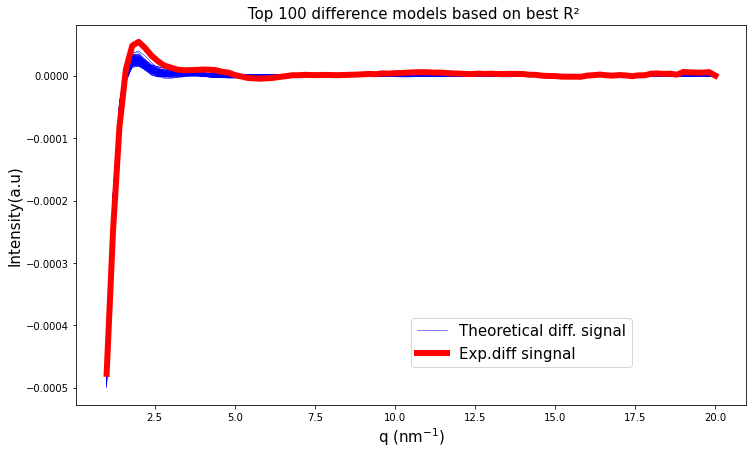

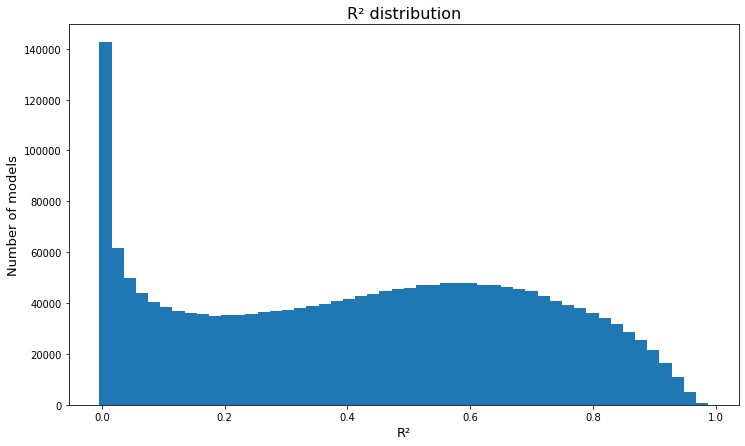

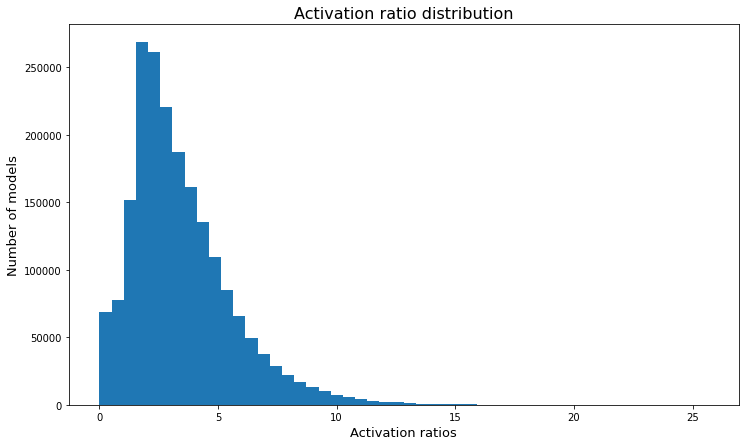

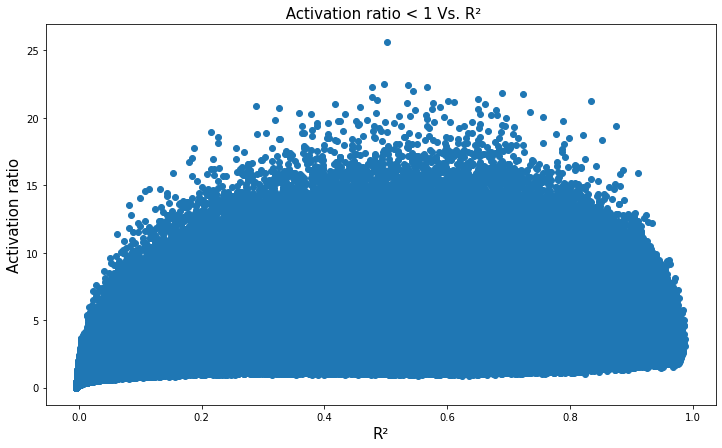

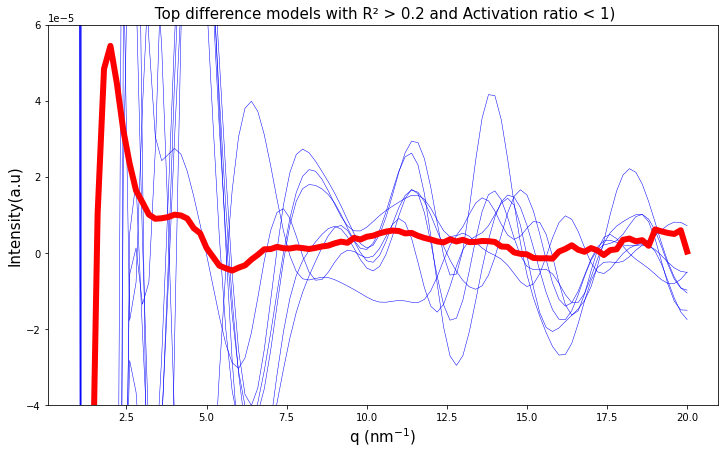

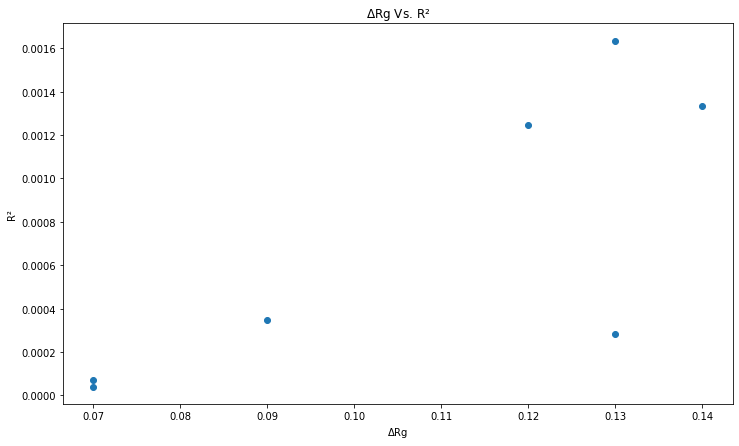

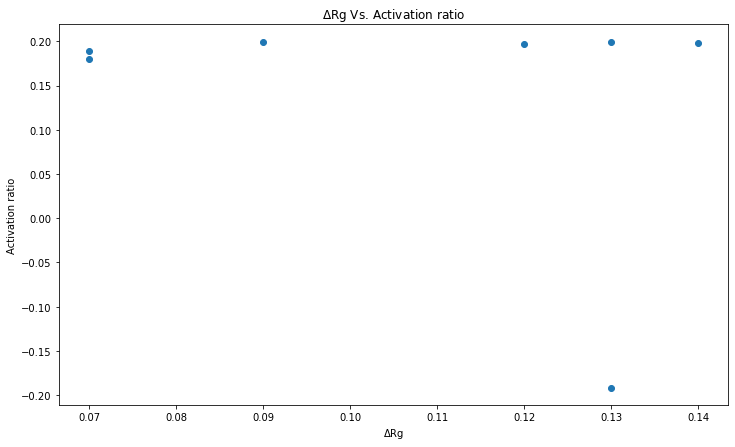

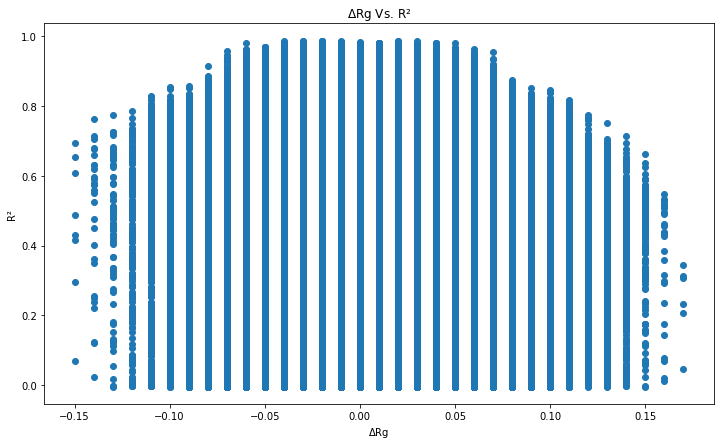

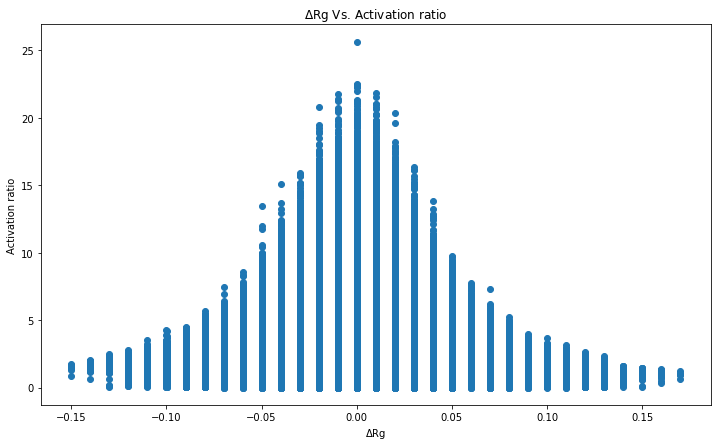

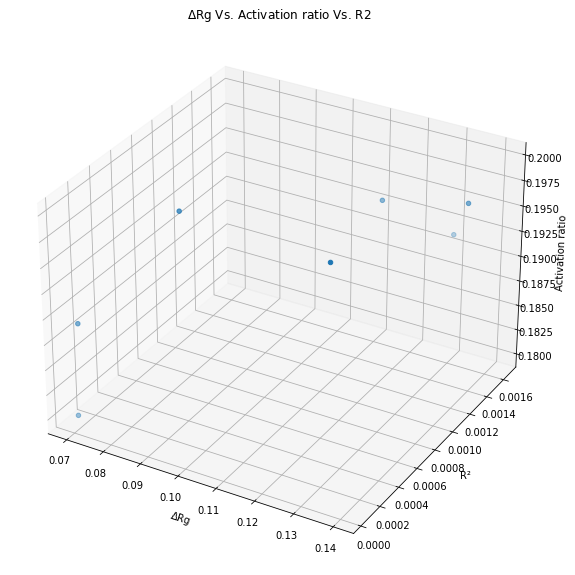

In [865]:
start_n = 0
q_max = 34
q_min = h1_q[0]
plot_top(start_n,2000,q_max,q_min,100)



In [752]:
#Changed to get path, this version only for subset of data (250 models).
def get_data_array(path, start, end):
    files = [os.path.join(path,file) for file in os.listdir(path)]
    files.sort()
    nested_array  = np.zeros((len(files)),dtype=object)
    
    flatten_array = np.empty((0))
    for i,file in enumerate(files):
            data  = np.load(file)
            nested_array[i] = data
            flatten_array = np.concatenate((flatten_array,data))
    return nested_array, flatten_array


def plot_top_r2(start,end,qmax,qmin,x):
    names = os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')
    names.sort()
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')]
    files.sort()
    
                                         
                                                            
    #Adjust SAXS q
    crysol_q = np.loadtxt(files[0], usecols=1, delimiter=',')*10
    crysol_indices = np.logical_and(q_min<=crysol_q, crysol_q<=q_max)
    q_cut = crysol_q[crysol_indices]
    
    #Adjust XFEL q and data 
    h1_af2 = h1[10:255]
    xfel_q = hamburg_q[10:255]
    xfel_indices = np.logical_and(q_min<=h1_q, h1_q<=q_max)
    xfel_q = xfel_q[xfel_indices]
    h1_cut = h1_af2[xfel_indices]
                                                            
    #Data paths
    R2_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/R2.npy'
    corr_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/correlations.npy'
    fopt_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/fopts.npy'
    model1_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/file1_index.npy'
    model2_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/file2_index.npy'
                                                                   
    #Initiate plot
    fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    #Interpolate XFEL data and scale
    exp_interpolated = interpolate_curve(q_cut,xfel_q,h1_cut)
    exp_scaled = exp_interpolated * q_cut

                                                            
    # Start retrieving data                                    
    R2 = np.load(R2_path)
    fopt = np.load(fopt_path)
    corr = np.load(corr_path)
    model1 =np.load(model1_path)
    model2 =np.load(model2_path)
  
    
    R2_indices = R2.argsort() 
    best_indices = R2_indices[-x-1:]
    best_R2 = R2[best_indices]
        
#Add array with correlations of all 
#Plot correlation as function of R2 or reverse

    indices_dark = []
    indices_light = []
 
    
    for index in best_indices:
        m1 = model1[index]
        m2 = model2[index]
        diff = get_diff(q_min,q_max,m1,m2)
        diff_scaled = diff * q_cut
        k,f = SSE(diff,exp_interpolated)
        ax.plot(q_cut, (diff/k), linewidth=0.5, color='Blue') 

        
        if k > 0:
            indices_dark.append(m1)
            indices_light.append(m2)
        
        else:
            indices_dark.append(m2)
            indices_light.append(m1)
            

    #XFEL Plot
    
    ax.plot(q_cut, exp_interpolated, linewidth=6.0, color='Red')
    #ax.plot(q_cut, exp_scaled, linewidth=6.0, color='Red')
    #ax.set_ylim([-4e-4,2e-4])
    ax.set_title(f' Top {n} models from Subset of data (last 250 models)', fontsize=15)
    ax.set_ylabel(f'Intensity(a.u)',fontsize=15)
    ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Top_{n}_models.png',bbox_inches='tight',facecolor=(1, 1, 1))
    

    #fig2, ax2 = plt.subplots(1, 1, figsize=(12, 7))
    #ax2.set_title(' fopt Vs. Pearson Correlation', fontsize=16)
    #ax2.set_ylabel('fopt', fontsize=13)
    #ax2.set_xlabel('Pearson Correlation', fontsize=13)
    #plt.scatter(corr,fopt)
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histogram_CC.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    fig5, ax5 = plt.subplots(1, 1, figsize=(12, 7))
    ax5.set_title('fopt distribution', fontsize=16)
    ax5.set_xlabel('fopt', fontsize=13)
    ax5.set_ylabel('Number of models', fontsize=13)
    plot =plt.hist(fopt, bins=50)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histogram_fopt.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    fig7, ax7= plt.subplots(1, 1, figsize=(12, 7))
    ax7.set_title('R² distribution', fontsize=16)
    ax7.set_xlabel('R²',fontsize=13)
    ax7.set_ylabel('Number of models', fontsize=13)
    plot =plt.hist(R2, bins=50,range=(-1,1))
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histogram_R2.png',bbox_inches='tight',facecolor=(1, 1, 1))
   
   

    fig6, ax6 = plt.subplots(1, 1, figsize=(12, 7))
    ax6.set_title('Pearson CC distribution', fontsize=16)
    ax6.set_xlabel('Pearson Correlation', fontsize=13)
    ax6.set_ylabel('Number of models', fontsize=13)
    plot =plt.hist(corr, bins=50)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histogram_R2.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
     #Plot occurences of model
   
    indices_dark = np.array(indices_dark)
    indices_light = np.array(indices_light)
    
    dark_unique, dark_counts = np.unique(indices_dark, return_counts=True)
    dark_label = [str(i).replace('.0','') for i in dark_unique]
    fig3, ax3 = plt.subplots(1, 1, figsize=(20, 7))
    plt.bar(np.linspace(0,dark_unique.shape[0],num=dark_unique.shape[0]), dark_counts, tick_label=dark_label, width=0.4)
    plt.xticks(rotation = 90)
    ax3.set_title(f'{n} best AF2 dark model candidates', fontsize=16)
    ax3.set_xlabel('Model number', fontsize=13)
    ax3.set_ylabel('Occurences' ,fontsize=13)
     
    
    light_unique, light_counts = np.unique(indices_light, return_counts=True)
    light_label = [str(i).replace('.0','') for i in light_unique]
    fig4, ax4 = plt.subplots(1, 1, figsize=(20, 7))
    plt.bar(np.linspace(0,light_unique.shape[0],num=light_unique.shape[0]), light_counts, tick_label=light_label, width=0.4)
    plt.xticks(rotation = 90)
    ax4.set_title(f'{n} best AF2 light model candidates', fontsize=16)
    ax4.set_xlabel('Model number', fontsize=13)
    ax4.set_ylabel('Occurences' ,fontsize=13)


In [ ]:
#Starting from 1750

### Get Rgs

#### Function

In [753]:
import re 

def get_rg(file):
    f = open(file, 'r')
    match = re.findall(r'\bRg: \w+.\w+', f.readlines()[0])
    rg = match[0].replace('Rg: ','')
    return (rg)
               
def store_rgs():
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/calc_scattering',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/calc_scattering')]
    files.sort()
    print(files[0])
    rgs = np.array(list(map(get_rg,files))).astype(float)
    np.save('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/rgs',rgs)
    print(rgs[0])
               

#### Run

In [1413]:
store_rgs()

/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/calc_scattering/unrelaxed_model_1_1.int
16.34


# EstimateOccupancy

## Scale Theoretical to XFEL

### Func_abs


In [ ]:

def SSE(v1,v2):
    calc_factor = lambda x: np.nansum((v1-(v2*x))**2)
    answer = optimize.fmin(func=calc_factor,x0=0.1,full_output=True,disp=False)
    minimum = answer[0]
    fopt = answer[1]
    return minimum,fopt

def get_diff(q_min,q_max,n,m):
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/abs',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/abs')]
    files.sort()
    #Decide what q-range
    crysol_q = np.loadtxt(files[0], usecols=1, delimiter=',',skiprows=1)*10
    crysol_indices = np.logical_and(q_min<=crysol_q, crysol_q<=q_max)
    q_cut = crysol_q[crysol_indices]
    
    
    #print(f'Running {2000-n} models')
    #Iterate over each file in the list of differences
    file1 = files[n]
    file2 = files[m]
    light = np.loadtxt(file1, usecols=2, delimiter=',',skiprows=1)
    dark = np.loadtxt(file2, usecols=2, delimiter=',',skiprows=1)
    af2_diff = (light-dark)[crysol_indices]
    
    return af2_diff

def calc_occupancy(q_min,q_max):
    #Load data
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/abs',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/abs')]
    files.sort()
    light_models = np.load('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/light_indices.npy')
    dark_models = np.load('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/dark_indices.npy')        
    
    #Adjust Theoretical q
    crysol_q = np.loadtxt(files[1], usecols=1, delimiter=',',skiprows=1)*10
    crysol_indices = np.logical_and(q_min<=crysol_q, crysol_q<=q_max)
    q_cut = crysol_q[crysol_indices]
    
    #Adjust XFEL q and data 
    xfel = h1[10:255]
    xfel_q = hamburg_q[10:255]
    xfel_indices = np.logical_and(q_min<=h1_q, h1_q<=q_max)
    xfel_q = xfel_q[xfel_indices]
    xfel = xfel[xfel_indices]
                                 

    dark_abs = np.sum(avg_S_off[150:175,:],axis = 0)/25
    dark_abs = (dark_abs - buffer_off*0.905)[10:255]
    dark_abs = dark_abs[xfel_indices]

    interpolated_abs = interpolate_curve(q_cut,xfel_q,dark_abs) 
    interpolated_diff = interpolate_curve(q_cut,xfel_q,xfel) 
    
    
    scale_abs_all = []
    occupancy = []
    for m1,m2 in zip(light_models,dark_models):
        model1 = np.loadtxt(files[m1], usecols=2, delimiter=',', skiprows=1)
        model2 = np.loadtxt(files[m2], usecols=2, delimiter=',',skiprows=1)[crysol_indices]
                         

        scale_abs,fopt = SSE(interpolated_abs, model2)
    
        theoretical_diff = get_diff(q_min,q_max,m1,m2)    

        
        scale_diff,fopt = SSE(interpolated_diff, theoretical_diff)
        scale_abs_all.append(scale_abs)
        occupancy.append((scale_diff/scale_abs)[0])
    
    scale_abs = np.array(scale_abs_all)
    scale_abs = np.mean(scale_abs)
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24, 7))
    #fig.suptitle('Example of scaled curves',fontsize=10)

    ax1.plot(q_cut, interpolated_abs/scale_abs, linewidth=3.0, color='Red', label='Experimental')
    ax1.plot(q_cut, model2, linewidth=3.0, color='Blue', label='Theoretical')
  
    ax1.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    ax1.set_yscale('log')
    ax1.set_title(' Exp. abs. signal scaled to Theoretical abs. signal', fontsize=15)
    ax1.set_ylabel('I$_{abs}$(s) [cm$^{-1}$]/c[mg/ml]',fontsize=15)
    ax1.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    #plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Scale_abs.png',bbox_inches='tight',facecolor=(1, 1, 1))

    
    ax2.plot(q_cut, interpolated_diff/scale_diff, linewidth=3.0, color='Red', label='Experimental')
    ax2.plot(q_cut, theoretical_diff, linewidth=3.0, color='Blue', label='Theoretical')

    ax2.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    ax2.set_title(f' Exp. diff signal scaled to Theoretical diff. signal', fontsize=15)
    ax2.set_ylabel('I$_{abs}$(s) [cm$^{-1}$]/c[mg/ml]',fontsize=15)
    ax2.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Scaled_Example.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
  
    occupancy = np.array(occupancy)    
    
    
    # Plots an example curve to see if the scaling is working
    #print(np.max(theoretical_diff))
    #print(np.max(model2))
    
    
  
    return occupancy

    

### Run Calc. of occupancy and plot histogram Abs scale

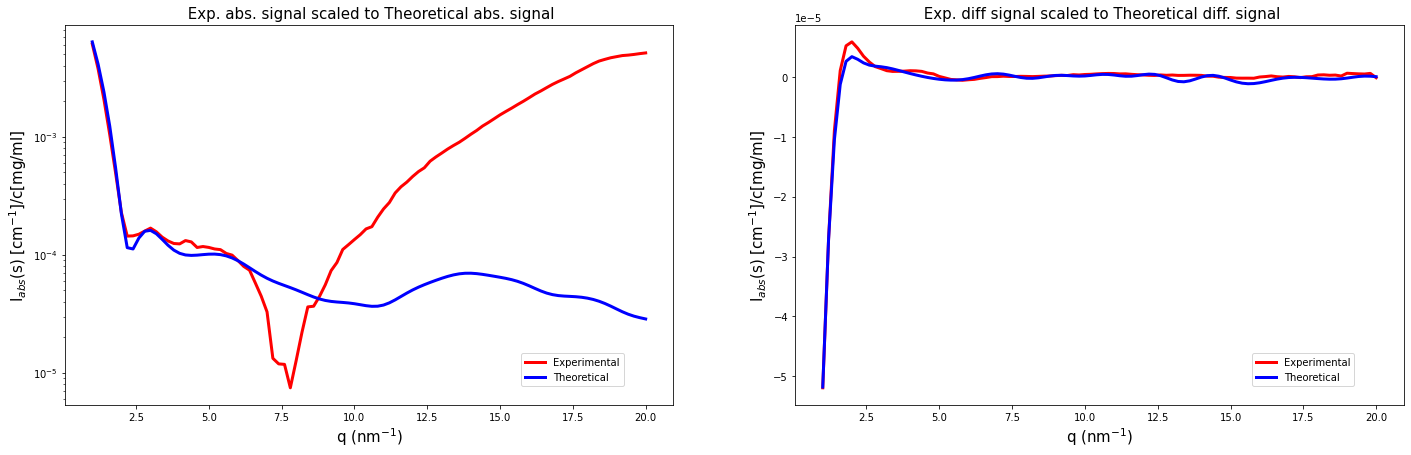

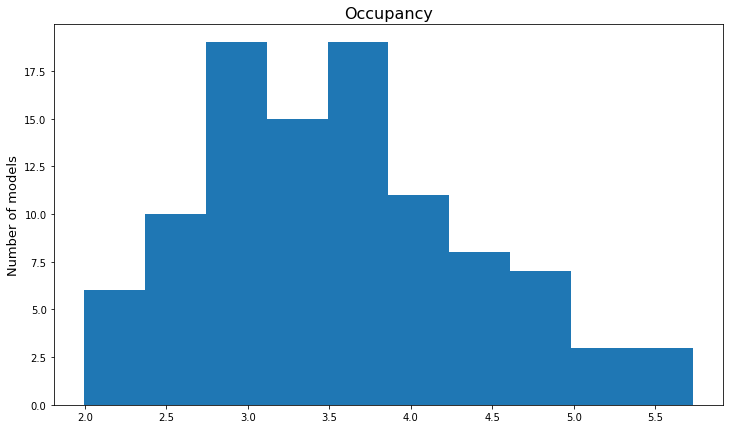

In [484]:
q_max = 20
q_min = h1_q[0]
occupancy=calc_occupancy(q_min,q_max)

fig, ax= plt.subplots(1, 1, figsize=(12, 7))
ax.set_title('Occupancy', fontsize=16)
#ax.set_xlabel('Occupancy',fontsize=13)
ax.set_ylabel('Number of models', fontsize=13)
plot=plt.hist(occupancy, bins=10)


### Run Calc. of occupancy and plot histogram, non abs


In [122]:

def SSE(v1,v2):
    calc_factor = lambda x: np.nansum((v1-(v2*x))**2)
    answer = optimize.fmin(func=calc_factor,x0=0.1,full_output=True,disp=False)
    minimum = answer[0]
    fopt = answer[1]
    return minimum,fopt

def get_diff(q_min,q_max,n,m):
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')]
    files.sort()
    #Decide what q-range
    crysol_q = np.loadtxt(files[0], usecols=1, delimiter=',')*10
    crysol_indices = np.logical_and(q_min<=crysol_q, crysol_q<=q_max)
    q_cut = crysol_q[crysol_indices]
    
    
    #print(f'Running {2000-n} models')
    #Iterate over each file in the list of differences
    file1 = files[n]
    file2 = files[m]
    light = np.loadtxt(file1, usecols=2, delimiter=',')
    dark = np.loadtxt(file2, usecols=2, delimiter=',')
    af2_diff = (light-dark)[crysol_indices]
    
    return af2_diff

def calc_occupancy(q_min,q_max):
    #Load data
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')]
    files.sort()
    light_models = np.load('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/light_indices.npy')
    dark_models = np.load('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/dark_indices.npy')        
    
    #Adjust Theoretical q
    crysol_q = np.loadtxt(files[1], usecols=1, delimiter=',')*10
    crysol_indices = np.logical_and(q_min<=crysol_q, crysol_q<=q_max)
    q_cut = crysol_q[crysol_indices]
    
    #Adjust XFEL q and data 
    xfel = h1[10:255]
    xfel_q = hamburg_q[10:255]
    xfel_indices = np.logical_and(q_min<=h1_q, h1_q<=q_max)
    xfel_q = xfel_q[xfel_indices]
    xfel = xfel[xfel_indices]                                
    

    dark_abs = np.sum(avg_S_off[150:175,:],axis = 0)/25
    dark_abs = (dark_abs - buffer_off*0.905)[10:255]
    dark_abs = dark_abs[xfel_indices]

    interpolated_abs = interpolate_curve(q_cut,xfel_q,dark_abs) * 1e5
    interpolated_diff = interpolate_curve(q_cut,xfel_q,xfel) * 1e5
    
    
    scale_abs_all = []
    occupancy = []
    for m1,m2 in zip(light_models,dark_models):
        model1 = np.loadtxt(files[m1], usecols=2, delimiter=',')
        model2 = np.loadtxt(files[m2], usecols=2, delimiter=',')[crysol_indices]
                         

        scale_abs,fopt = SSE(interpolated_abs, model2)
    
        theoretical_diff = get_diff(q_min,q_max,m1,m2)    

        
        scale_diff,fopt = SSE(interpolated_diff, theoretical_diff)
        scale_abs_all.append(scale_abs)
        occupancy.append((scale_diff/scale_abs)[0])
    
    scale_abs = np.array(scale_abs_all)
    scale_abs = np.mean(scale_abs)
    print(scale_abs, scale_diff)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(q_cut, interpolated_abs/scale_abs, linewidth=3.0, color='Red', label='Experimental')
    ax.plot(q_cut, model2, linewidth=3.0, color='Blue', label='Theoretical')
  
    ax.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    ax.set_yscale('log')
    ax.set_title(f' Absolute Intensity Dark)', fontsize=15)
    ax.set_ylabel(f'Intensity(a.u)',fontsize=15)
    
    ax.set_ylabel(f'Intensity(a.u)',fontsize=15)
    
    ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(q_cut, interpolated_diff/scale_abs, linewidth=3.0, color='Red', label='Experimental')
    ax.plot(q_cut, theoretical_diff, linewidth=3.0, color='Blue', label='Theoretical')

    ax.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    ax.set_title(f' $\Delta$I(q))', fontsize=15)
    ax.set_ylabel(f'Intensity(a.u)',fontsize=15)
    ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    
  
    occupancy = np.array(occupancy)    
    np.save('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/scale_abs',scale_abs)
    
    # Plots an example curve to see if the scaling is working
    #print(np.max(theoretical_diff))
    #print(np.max(model2))
    
    
  
    return occupancy

    

0.000725405759150632 [0.00345459]


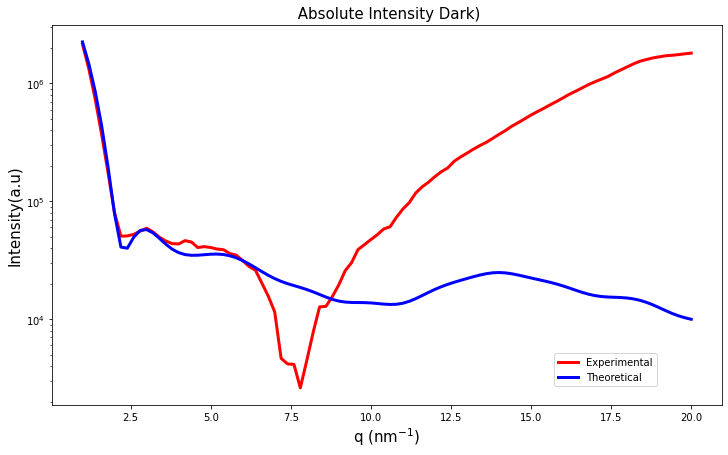

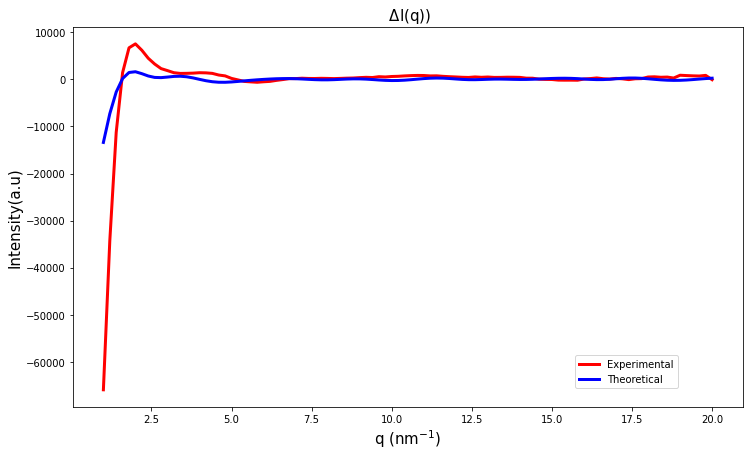

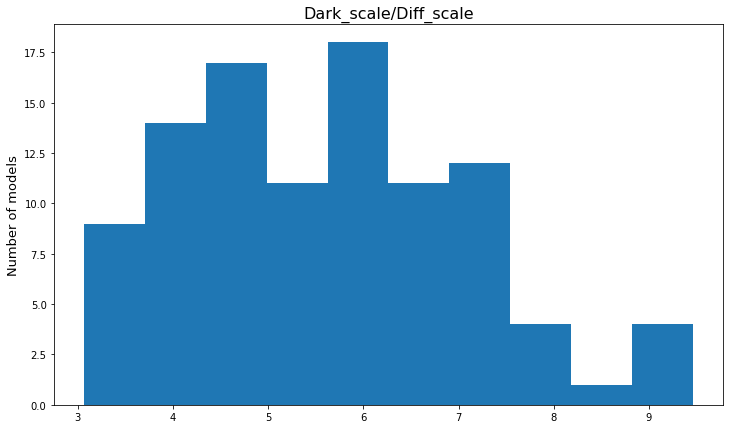

In [123]:
q_max = 20
q_min = h1_q[0]
occupancy=calc_occupancy(q_min,q_max)

fig, ax= plt.subplots(1, 1, figsize=(12, 7))
ax.set_title('Dark_scale/Diff_scale', fontsize=16)
#ax.set_xlabel('Occupancy',fontsize=13)
ax.set_ylabel('Number of models', fontsize=13)
plot=plt.hist(occupancy, bins=10)

### Make matrix for searching

In [ ]:
#Now get the R2 values instead
def get_data_array():
    correlations = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/R2',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/R2')]
    correlations.sort()
    corr_values  = np.zeros((len(correlations)),dtype=object)
    corr_values_flatten = np.empty((0))
    for correlation in correlations:
            data  = np.load(correlation)
            corr_values[correlations.index(correlation)] = data
            if data.size > 0:
                corr_values_flatten = np.concatenate((corr_values_flatten,data))
    return corr_values, corr_values_flatten
        

### Get_diff function

In [1778]:
def get_diff(q_min,q_max,n,m):
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')]
    files.sort()
    #Decide what q-range
    crysol_q = np.loadtxt(files[0], usecols=1, delimiter=',')*10
    crysol_indices = np.logical_and(q_min<=crysol_q, crysol_q<=q_max)
    q_cut = crysol_q[crysol_indices]
    
    
    #print(f'Running {2000-n} models')
    #Iterate over each file in the list of differences
    file1 = files[n]
    file2 = files[m]
    light = np.loadtxt(file1, usecols=2, delimiter=',')
    dark = np.loadtxt(file2, usecols=2, delimiter=',')
    af2_diff = (light-dark)[crysol_indices]
    
    return af2_diff

In [1603]:
def SSE(v1,v2):
    calc_factor = lambda x: np.nansum((v1-(v2*x))**2)
    answer = optimize.fmin(func=calc_factor,x0=1,full_output=True,disp=False)
    minimum = answer[0]
    fopt = answer[1]
    return minimum,fopt

### Plot diff

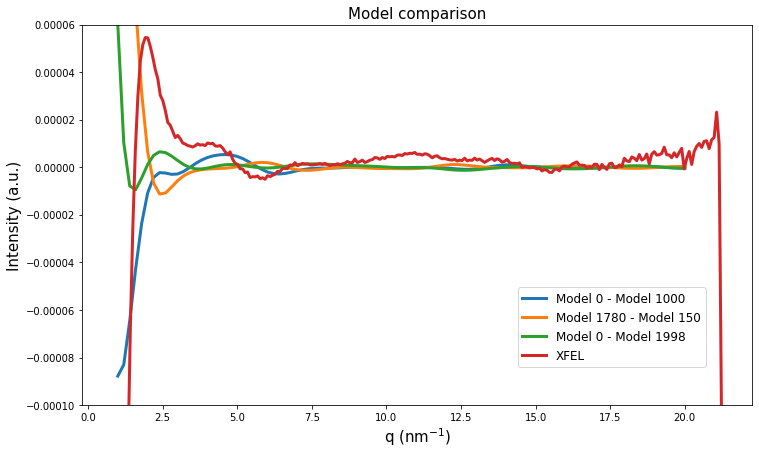

In [23]:
files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')]
files.sort()
ref = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/ref.txt'
ref = np.loadtxt(ref,usecols=[1,2], delimiter=',').T
crysol_q = np.loadtxt(files[0], usecols=1, delimiter=',')*10
crysol_indices = np.logical_and(q_min<=crysol_q, crysol_q<=q_max)
q_cut = crysol_q[crysol_indices]
xfel_indices = np.logical_and(q_min<=h1_q, h1_q<=q_max)

h1_af2 = h1[10:255]
h1_q = hamburg_q[10:255]

m = 0 
n = 100

q_max = 20
q_min = h1_q[0]

diff1 = get_diff(q_min,q_max,0,1000)
diff2 = get_diff(q_min,q_max,1780,150)
diff3 = get_diff(q_min,q_max,160,1998)

fig, ax = plt.subplots(1, 1, figsize=(12, 7))




ax.plot(crysol_q[crysol_indices], diff1*1e-8, linewidth=3.0,label='Model 0 - Model 1000')
ax.plot(crysol_q[crysol_indices], diff2*1e-8, linewidth=3.0,label='Model 1780 - Model 150')
ax.plot(crysol_q[crysol_indices], diff3*1e-8, linewidth=3.0,label='Model 0 - Model 1998')
ax.plot(h1_q[xfel_indices], h1_af2[xfel_indices],linewidth=3.0,label='XFEL')
ax.set_title('Model comparison',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_ylim([-.0001,.00006])
#ax.set_xlim([0.8,3])
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)

ax.legend(loc=(0.65,0.1), frameon = True,fontsize=12)
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Model_example.png',bbox_inches='tight',facecolor=(1, 1, 1))

## Get Top N Models And Plot

### Functions

In [494]:
#Changed to get R2 instead 
#Update var names
def get_data_array(path):
    files = [os.path.join(path,file) for file in os.listdir(path')]
    files.sort()
    nested_array  = np.zeros((len(correlations)),dtype=object)
    flatten_array = np.empty((0))
    for values in file:
            data  = np.load(correlation)
            corr_values[correlations.index(correlation)] = data
            if data.size > 0:
                corr_values_flatten = np.concatenate((corr_values_flatten,data))
    return corr_values, corr_values_flatten





def plot_top(n,qmax,qmin):
    names = os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')
    names.sort()
    files = [os.path.join('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities',file) for file in os.listdir('/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/intensities')]
    files.sort()
    crysol_q = np.loadtxt(files[0], usecols=1, delimiter=',')*10
    
    R2_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/R2'
    corr_path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/AF2_simulated_xfel_q/correlations'
                                                                   
    crysol_indices = np.logical_and(q_min<=crysol_q, crysol_q<=q_max)
    q_cut = crysol_q[crysol_indices]
    h1_af2 = h1[10:255]
    h1_q = hamburg_q[10:255]
    fig1, ax = plt.subplots(1, 1, figsize=(12, 7))
    xfel_indices = np.logical_and(q_min<=h1_q, h1_q<=q_max)
    xfel_q = h1_q[xfel_indices]
    h1_cut = h1_af2[xfel_indices]
    exp_interpolated = interpolate_curve(q_cut,xfel_q,h1_cut)
    exp_scaled = exp_interpolated * q_cut

    nested_R2, all_R2 = get_data_array()
    
    all_R2_sorted = all_R2.argsort()
    top_R2 = all_R2_sorted[-n-1:]
    top_R2 = all_R2[top_R2]
    R2_indices = np.zeros((n),dtype=object)
    
    for i,array in enumerate(nested_R2):
        for index,r2 in enumerate(top_R2):
            j = np.argwhere(array == r2)
            R2_indices[index] = (i,j[0][0])

#Add array with correlations of all 
#Plot correlation as function of R2 or reverse
            
    for index in indices:
        m1,m2,sign = index
        diff = get_diff(q_min,q_max,m1,m2)
        diff_scaled = diff * q_cut
        #Add get correlation 
        #Add get k factor 
        k,fopt = SSE(diff,exp_interpolated)
        ax.plot(q_cut, (diff/k), linewidth=0.5, color='Blue') 
        
        
            

    #XFEL Plot
    
    ax.plot(q_cut, exp_interpolated, linewidth=6.0, color='Red')
    #ax.plot(q_cut, exp_scaled, linewidth=6.0, color='Red')
    #ax.set_ylim([-4e-4,2e-4])
    ax.set_title(f'Top {n} models', fontsize=15)
    ax.set_ylabel(f'Intensity(a.u)',fontsize=15)
    ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Top_{n}_models.png',bbox_inches='tight',facecolor=(1, 1, 1))
    

    fig2, ax2 = plt.subplots(1, 1, figsize=(12, 7))
    ax2.set_title('Pearson Correlation for AF2 models', fontsize=16)
    ax2.set_xlabel('Pearson Correlation', fontsize=13)
    ax2.set_ylabel('Number of models', fontsize=13)
    plot =plt.hist(all_corr, bins=50)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histogram_CC.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    fig5, ax5 = plt.subplots(1, 1, figsize=(12, 7))
    ax5.set_title('R² for AF2 models', fontsize=16)
    ax5.set_xlabel('R²', fontsize=13)
    ax5.set_ylabel('Number of models', fontsize=13)
    plot =plt.hist(all_corr, bins=50)
    plt.savefig(f'/home/leonardo/Solution_Scattering_2208/Plots/Histogram_R2.png',bbox_inches='tight',facecolor=(1, 1, 1))
    
    
    #Plot occurences of model
    indices_tot1 = np.array([i[0] for i in indices])
    indices_tot2 = np.array([i[1] for i in indices])
    indices_tot = np.concatenate((indices_tot1,indices_tot2))
    total_unique, total_counts = np.unique(indices_tot, return_counts=True)
    
    
    indices1_dark = np.array([i[1] for i in indices if i[2] == 1])
    indices2_dark = np.array([i[0] for i in indices if i[2] == -1])
    indices_dark = np.concatenate((indices1_dark,indices2_dark))
    dark_unique, dark_counts = np.unique(indices_dark, return_counts=True)
    dark_label = [str(i).replace('.0','') for i in dark_unique]
    fig3, ax3 = plt.subplots(1, 1, figsize=(20, 7))
    plt.bar(np.linspace(0,dark_unique.shape[0],num=dark_unique.shape[0]), dark_counts, tick_label=dark_label, width=0.4)
    plt.xticks(rotation = 90)
    ax3.set_title(f'{n} best AF2 dark model candidates', fontsize=16)
    ax3.set_xlabel('Model number', fontsize=13)
    ax3.set_ylabel('Occurences' ,fontsize=13)
     
    
    indices1_light = np.array([i[0] for i in indices if i[2] == 1])
    indices2_light = np.array([i[1] for i in indices if i[2] == -1])
    indices_light = np.concatenate((indices1_light,indices2_light))
    light_unique, light_counts = np.unique(indices_light, return_counts=True)
    light_label = [str(i).replace('.0','') for i in light_unique]
    fig4, ax4 = plt.subplots(1, 1, figsize=(20, 7))
    plt.bar(np.linspace(0,light_unique.shape[0],num=light_unique.shape[0]), light_counts, tick_label=light_label, width=0.4)
    plt.xticks(rotation = 90)
    ax4.set_title(f'{n} best AF2 light model candidates', fontsize=16)
    ax4.set_xlabel('Model number', fontsize=13)
    ax4.set_ylabel('Occurences' ,fontsize=13)

    

### Calc top N Models 

[1412595 1784760   77703  251512 1678588]
[ 0.99976956 -0.99977426  0.99979763  0.99980674 -0.99984008]
[ 0.99976956 -0.99977426  0.99979763  0.99980674 -0.99984008]


IndexError: index 4 is out of bounds for axis 0 with size 4

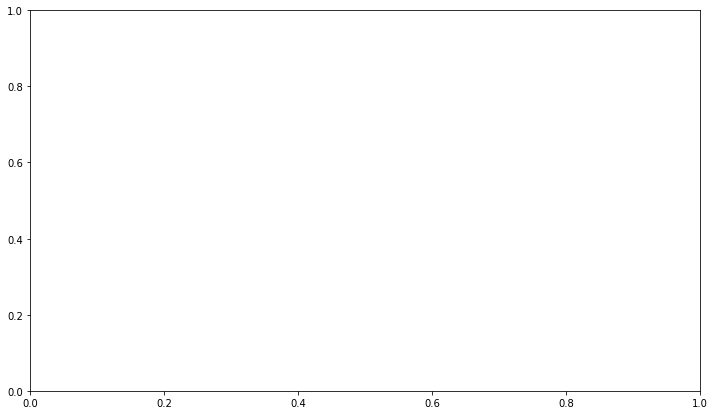

In [493]:
q_max = 34
q_min = h1_q[0]
plot_top(4,q_max,q_min)

# Estimate activation factor FEB 23

bertnsson paper## Load SAXS Data FEB 23 - Measurement 1


### Plot and compare to SAXS NOV 22

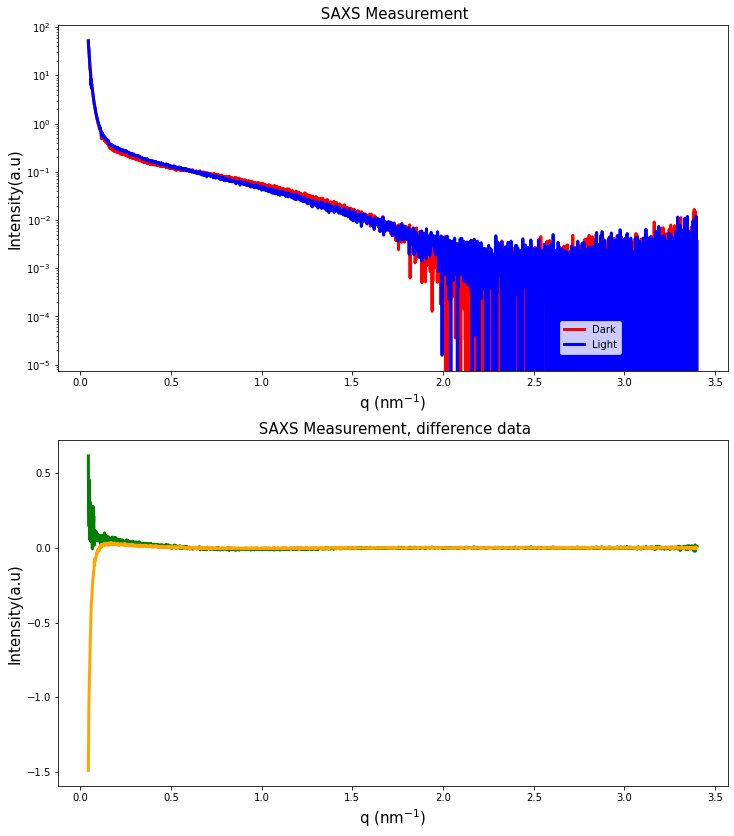

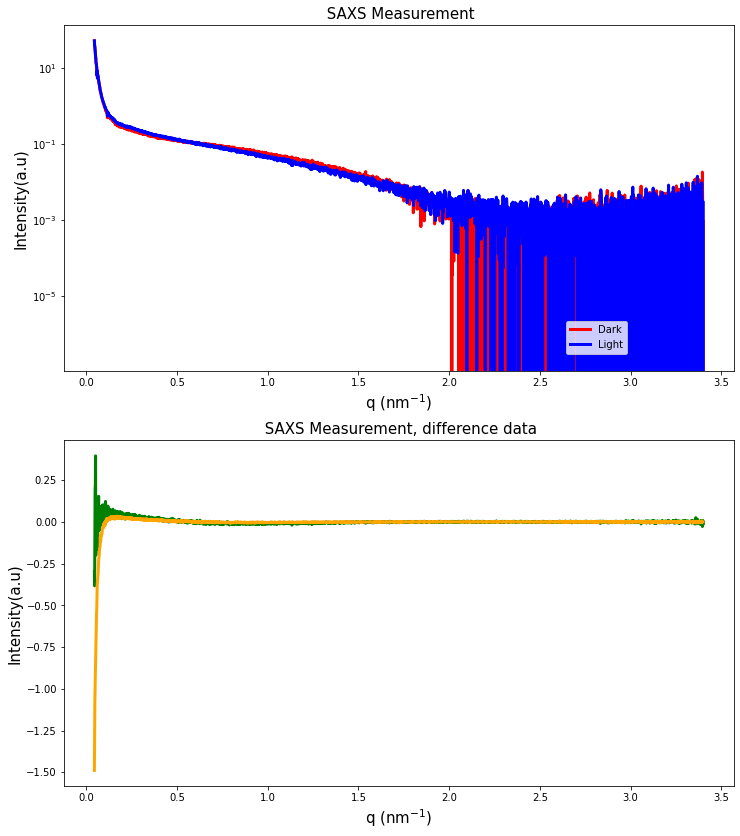

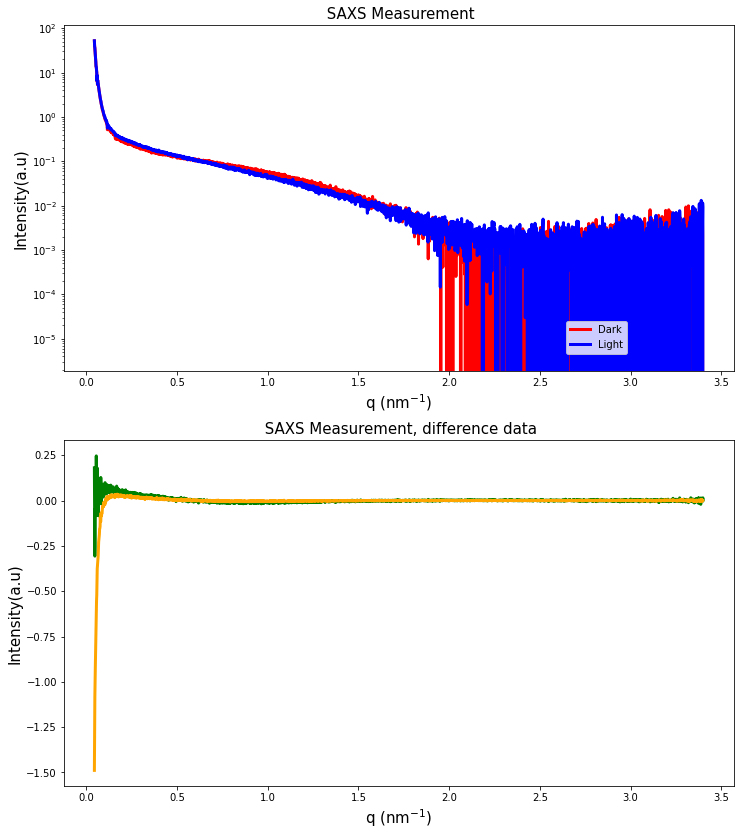

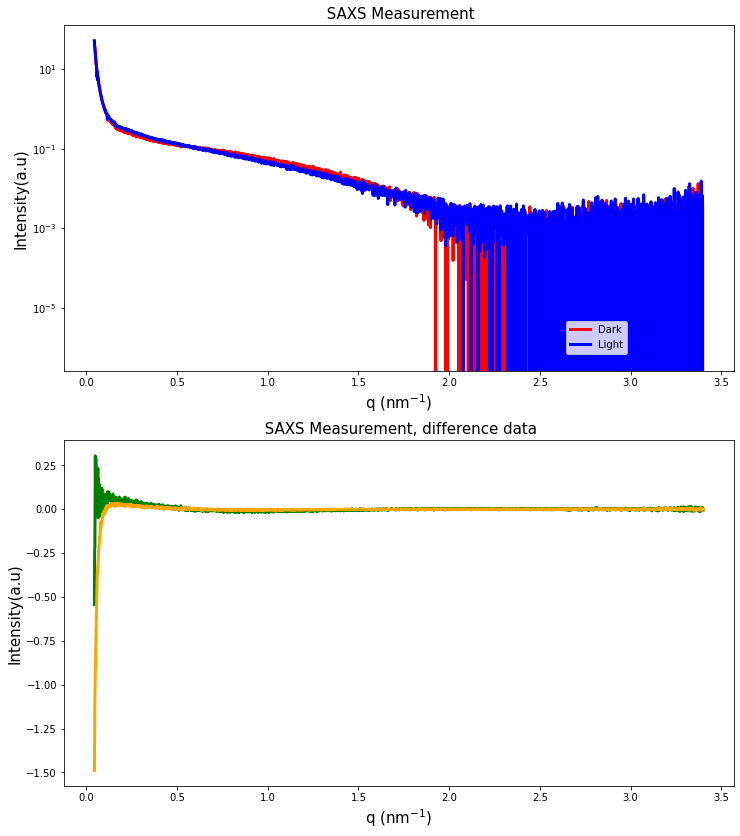

In [823]:
#Load data from Diamond FEB23 and compare to NOV22
dark_files = [os.path.join('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Dark_sub/csv',file) for file in os.listdir('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Dark_sub/csv')]
dark_files.sort()
light_files = [os.path.join('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Light_sub/csv',file) for file in os.listdir('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_measurement1_Light_sub/csv')]
light_files.sort()
    
lights = []
darks = []
E_light = []
E_dark = []


for light,dark in zip(light_files,dark_files):
    light_data = pd.read_csv(light, names=['q', 'I', 'E'],index_col=False)
    dark_data = pd.read_csv(dark, names=['q', 'I', 'E'],index_col=False)
    q_dark =  dark_data['q'].to_numpy()*10
    q_light = light_data['q'].to_numpy()*10
    I_light = light_data['I'].to_numpy()
    I_dark = dark_data['I'].to_numpy()
    e_dark = dark_data['E'].to_numpy()
    e_light = light_data['E'].to_numpy()
    
    E_dark.append(e_dark)
    E_light.append(e_light)
    lights.append((I_light))
    darks.append((I_dark))
    diff = (I_light - I_dark)
    
    
    
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 14))
    ax1.plot(q_dark, I_dark, linewidth=3.0, color='Red', label='Dark')
    ax1.plot(q_light, I_light, linewidth=3.0, color='Blue', label='Light')
    ax1.set_yscale('log')
    ax1.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
    ax1.set_title(f' SAXS Measurement', fontsize=15)
    ax1.set_ylabel(f'Intensity(a.u)',fontsize=15)
    ax1.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    
    
    
    ax2.plot(q_light, diff, linewidth=3.0, color='Green', label='Difference')
    ax2.plot(df_temp20['q'].to_numpy()*10, diff_saxs1, linewidth=3.0, color='Orange', label='Difference')
    #ax2.set_yscale('log')
    ax2.set_title(f' SAXS Measurement, difference data', fontsize=15)
    ax2.set_ylabel(f'Intensity(a.u)',fontsize=15)
    ax2.set_xlabel('q (nm$^{-1}$)',fontsize=15)
    
lights = np.array(lights, dtype=float)
darks = np.array(darks, dtype=float)

### Average dark runs and light runs at 10 sec and 20 sec illumination 

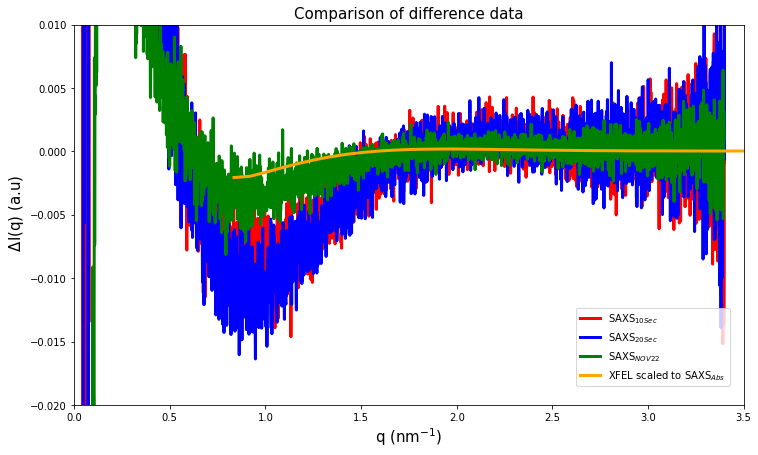

In [836]:
# Average runs
a = lights[0]
light_10sec = (lights[0] + lights[1]) /2
dark_10sec = (darks[0] + darks[1]) /2

light_20sec = (lights[2] + lights[3]) /2
dark_20sec = (darks[2] + darks[3]) /2

diff_10sec =light_10sec - dark_10sec
diff_20sec = light_20sec - dark_20sec

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.set_ylim([-.02,.01])
ax.set_xlim([0,3.5])
ax.set_ylabel(f' $\Delta$I(q) (a.u)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_title('Comparison of difference data',fontsize=15)
ax.plot(q_light, diff_10sec, linewidth=3.0, color='Red', label='SAXS$_{10 Sec}$')
ax.plot(q_light, diff_20sec, linewidth=3.0, color='Blue', label='SAXS$_{20 Sec}$')
ax.plot(df_temp20['q'].to_numpy()*10, diff_saxs1, linewidth=3.0, color='Green', label='SAXS$_{NOV22}$')
ax.plot(hamburg_q,h1/abs_scale,linewidth=3.0, label='XFEL scaled to SAXS$_{Abs}$', color='Orange')
ax.legend(loc=(0.75,0.05), frameon = True,fontsize=10)
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Comparison_of_difference_data.png',bbox_inches='tight',facecolor=(1, 1, 1))

# Average errors
E_light_10sec = (E_light[0] + E_light[1]) /2
E_dark_10sec = (E_dark[0] + E_dark[1]) /2

E_light_20sec = (E_light[2] + E_light[3]) /2
E_dark_20sec = (E_dark[2] + E_dark[3]) /2


## Dark 

### Prep data

In [851]:
dark_exp = np.sum(avg_S_off[150:175,:],axis = 0)/25
dark_exp = dark_exp - buffer_off*0.935
q_range = [1.1,1.2]

q_dark_indices = np.logical_and(q_dark>q_range[0], q_range[1]>q_dark)
exfel_indices = np.logical_and(hamburg_q>q_range[0], q_range[1]>hamburg_q)


q_dark_cut = q_dark[q_dark_indices]
exfel_q =hamburg_q[exfel_indices]

dark_10sec_cut = dark_10sec[q_dark_indices]
E_dark_10sec_cut = E_dark_10sec[q_dark_indices]
dark_exp_cut = dark_exp[exfel_indices]


exp_interpolated_dark = interpolate_curve(q_dark_cut,exfel_q,dark_exp_cut)
dark_scale = chi_sq(dark_10sec_cut,exp_interpolated_dark[0],E_dark_10sec_cut)[0]
print(dark_scale)*
1/dark_scale[0]

Optimization terminated successfully.
         Current function value: 91.590007
         Iterations: 21
         Function evaluations: 42
[4.01544189]


0.24903859307787016

### Plot

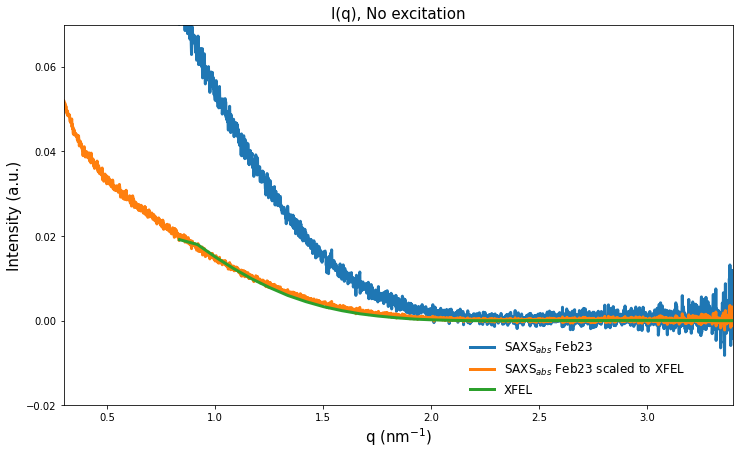

In [854]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#ax.plot(q_dark, exp_interpolated_dark,linewidth=3.0, label='XFEL_interpolated') 
ax.plot(q_dark, dark_10sec,linewidth=3.0, label='SAXS$_{abs}$ Feb23')
ax.plot(q_dark, dark_10sec*1/3.7,linewidth=3.0, label='SAXS$_{abs}$ Feb23 scaled to XFEL')
ax.plot(hamburg_q, dark_exp,linewidth=3.0, label='XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q), No excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
#ax.set_yscale('log')
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Dark_scaled_SAXS_FEB23',bbox_inches='tight',facecolor=(1, 1, 1))

## Diff

### Prep data

In [623]:
diff_exp = h1
q_range = [0.8,1]

q_dark_indices = np.logical_and(q_dark>q_range[0], q_range[1]>q_dark)
exfel_indices = np.logical_and(hamburg_q>q_range[0], q_range[1]>hamburg_q)


q_dark_cut = q_dark[q_dark_indices]
exfel_q =hamburg_q[exfel_indices]

diff_10sec_cut = diff_20sec[q_dark_indices]
E_diff_10sec = E_dark_10sec[q_dark_indices]
diff_exp_cut = diff_exp[exfel_indices]


exp_interpolated_diff = interpolate_curve(q_dark_cut,exfel_q,diff_exp_cut)
diff_scale = chi_sq(diff_10sec_cut,exp_interpolated_diff[0],E_diff_10sec)[0]
print(diff_scale)
1/diff_scale[0]

Optimization terminated successfully.
         Current function value: 99.226501
         Iterations: 17
         Function evaluations: 34
[17.75415039]


0.05632485801900414

### Plot

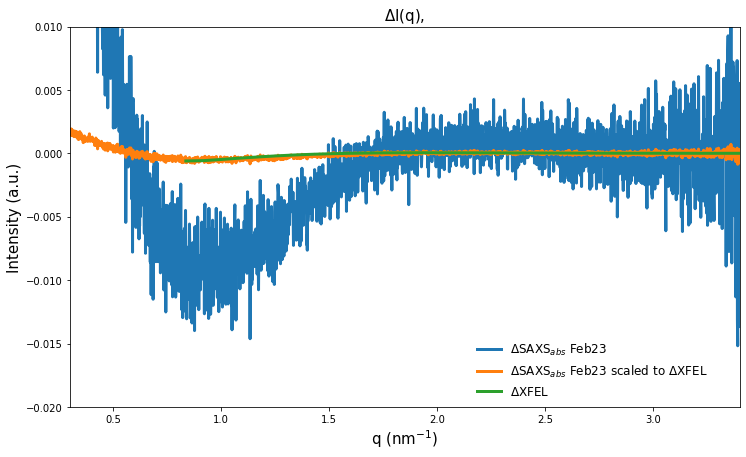

In [859]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#ax.plot(q_dark, exp_interpolated_dark,linewidth=3.0, label='XFEL_interpolated') 
ax.plot(q_dark, diff_10sec,linewidth=3.0, label=r'$\Delta$SAXS$_{abs}$ Feb23')
ax.plot(q_dark, diff_10sec*1/diff_scale[0],linewidth=3.0, label='$\Delta$SAXS$_{abs}$ Feb23 scaled to $\Delta$XFEL')
ax.plot(hamburg_q, diff_exp,linewidth=3.0, label='$\Delta$XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'$\Delta$I(q), ',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.01])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Diff_scaled_SAXS_FEB23',bbox_inches='tight',facecolor=(1, 1, 1))

### Calc activation factor

In [628]:
# Based on scaling XFEL to exp. 
#
#
activation_factor = (diff_scale/dark_scale)
print(1/diff_scale)
print(dark_scale)
print(activation_factor[0])
print(1/activation_factor[0])

[0.05632486]
[3.45599365]
5.137205729120676
0.19465835178284127


## Load SAXS Data FEB 23 - Measurement 2

In [566]:
#Load data from Diamond FEB23 and compare to NOV22
dark_files = [os.path.join('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv',file) for file in os.listdir('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Dark/csv')]
dark_files.sort()
light_files = [os.path.join('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv',file) for file in os.listdir('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_sample2/Light/csv')]
light_files.sort()

dark_buffer = [os.path.join('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/dark_buffer', file) for file in os.listdir('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/dark_buffer')]
dark_buffer.sort()
light_buffer = [os.path.join('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/light_buffer',file) for file in os.listdir('/home/leonardo/SAXS_DATA_FEB23/AsLOV2_buffer/csv/light_buffer')]
light_buffer.sort()

data = zip(light_files, dark_files,dark_buffer,light_buffer)

lights = []
darks = []
Light_buffer = []
Dark_buffer = []
difference= []

## Need to reformat csv files. 
for light,dark, dark_buffer, light_buffer in data:

    light_data = pd.read_csv(light, names=['q', 'I', 'E'],index_col=False,skiprows=[0,1,2])
    dark_data = pd.read_csv(dark, names=['q', 'I', 'E'],index_col=False,skiprows=[0,1,2])

    dark_buffer_data = pd.read_csv(dark_buffer, names=['q', 'I', 'E'],index_col=False,skiprows=[0,1,2,])
    light_buffer_data = pd.read_csv(light_buffer, names=['q', 'I', 'E'],index_col=False,skiprows=[0,1,2])
    q_dark =  dark_data['q'].to_numpy()*10
    q_light = light_data['q'].to_numpy()*10
    I_light = light_data['I'].to_numpy() - light_buffer_data['I'].to_numpy()
    I_dark = dark_data['I'].to_numpy() - dark_buffer_data['I'].to_numpy()
    diff = (I_light - I_dark)
    
    lights.append(I_light)
    darks.append(I_dark)
    difference.append(diff)

diffs = np.array(difference, dtype=float)
lights = np.array(lights, dtype=float)
darks = np.array(darks, dtype=float)
light_buffer = np.array(Light_buffer, dtype=float)
dark_buffer = np.array(Dark_buffer, dtype=float)


## Plot comparison of diff data, abs data and excited data. 

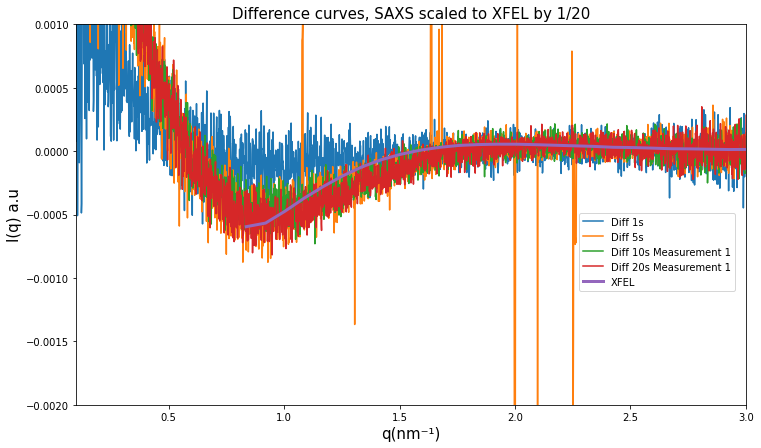

In [739]:
time_points = {0:'1s', 1:'2s', 2:'5s', 3:'10s' }
#fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 21))

for i in enumerate(darks):
    dark = i[1]
    i = i[0] 
    ax1.set_title('Absolute curves, dark', fontsize=15)
    ax1.set_xlabel(r'q(nm⁻¹)',fontsize=15)
    ax1.set_ylabel('I(q) a.u', fontsize=15)
    ax1.plot(q_dark,dark, label=f'Dark {time_points[i]}')
    ax1.legend(loc=(0.75,0.5), frameon = True,fontsize=10)

for i in enumerate(lights):
    light = i[1]
    i = i[0] 
    ax2.set_title('Absolute curves, Light', fontsize=15)
    ax2.set_xlabel(r'q(nm⁻¹)',fontsize=15)
    ax2.set_ylabel('I(q) a.u', fontsize=15)
    ax2.plot(q_light,light, label=f'Light {time_points[i]}')
    ax2.legend(loc=(0.75,0.5), frameon = True,fontsize=10)

diffs = lights-darks
fig, ax3 = plt.subplots(1, 1, figsize=(12, 7))
for i in enumerate(diffs):
    diff = i[1]
    i = i[0] 
    if i ==1 or i==3:
        continue
    ax3.set_title('Difference curves, SAXS scaled to XFEL by 1/20', fontsize=15)
    ax3.set_xlabel(r'q(nm⁻¹)',fontsize=15)
    ax3.set_ylabel('I(q) a.u', fontsize=15)
    ax3.plot(q_light,diff/20, label=f'Diff {time_points[i]}')
    ax3.set_ylim([-.002,.001])
    ax3.set_xlim([0.1,3])
    

ax3.plot(q_light,diff_10sec/20, label=f'Diff 10s Measurement 1')
ax3.plot(q_light,diff_20sec/20, label=f'Diff 20s Measurement 1')
ax3.plot(hamburg_q, diff_exp,linewidth=3.0, label='XFEL')
ax3.legend(loc=(0.75,0.3), frameon = True,fontsize=10)

## Visualisation of activation factor


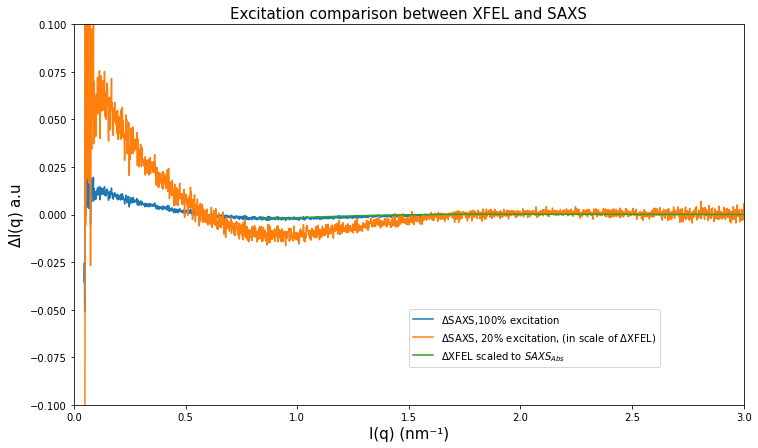

In [835]:
# Interpolate SAXS on XFEL data
differences = np.array([diffs[0], diffs[2], diff_10sec, diff_20sec])
time_points = {0:'1s', 1:'5s', 2:'10s', 3:'20s' }
interpolated_diffs = []
abs_scale = 1/dark_scale

for diff in differences: 
    interpolated_diff = interpolate_curve(hamburg_q,q_light,diff)
    interpolated_diffs.append(interpolated_diff)
    
fig, ax3 = plt.subplots(1, 1, figsize=(12, 7))
for i in enumerate(interpolated_diffs):
    diff = i[1]
    i = i[0]
    #ax3.plot(hamburg_q,diff, label = f'Illumination time: {time_points[i]}')
    ax3.set_xlim([0,3])
    ax3.set_ylim([-0.1,.1])

ax3.plot(q_light,differences[-1]/activation_factor, label = f'$\Delta$SAXS,100% excitation ')
ax3.plot(q_light,differences[-1], label = f'$\Delta$SAXS, 20% excitation, (in scale of $\Delta$XFEL)')
ax3.plot(hamburg_q,diff_exp/abs_scale, label = '$\Delta$XFEL scaled to $SAXS_{Abs}$')
ax3.set_title('Excitation comparison between XFEL and SAXS', fontsize=15)
ax3.set_ylabel(r'$\Delta$I(q) a.u', fontsize=15)
ax3.set_xlabel(r'I(q) (nm⁻¹)', fontsize=15)
#ax3.hlines(0.014, xmin = 0.13, xmax = 0.15, color='black', linestyle='-')
#ax3.hlines(0.07, xmin = 0.13, xmax = 0.15, color='black', linestyle='-')
ax3.legend(loc=(0.5,0.1), frameon = True,fontsize=10)
#ax3.vlines(0.14, ymin = 0.07, ymax = 0.014, color='black', linestyle='-')
#plt.text(0.2,.07,'Activation factor of 0.2')
plt.savefig(f'/home/leonardo/Solution_Scattering_2208/plots/Comparison_of_activation_factor_2.png',bbox_inches='tight',facecolor=(1, 1, 1))



# Test with Unfolded Helix from Collabfold


## Load curve bsaed on data from collab prediction

In [1060]:
path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/NO_helix/no_helix.txt'
nohelix = np.loadtxt(path,usecols=[1,2], delimiter=',',skiprows=1).T

# no helixq = nohelix[0]
q = nohelix[0]
I =nohelix[1]

# Dark
path = '/home/leonardo/Solution_Scattering_2208/AsLOV2/NO_helix/ref/dark.txt'
dark = np.loadtxt(path,usecols=[1,2], delimiter=',',skiprows=1).T
q = dark[0] *10 
I_dark = dark[1]
# Get a dark structure and take nohelix - ref 
theory_diff = (I - I_dark)

            

[5.85253906e-05]
0.8724509337570171
0.09778303522261449
0.9724046682121505


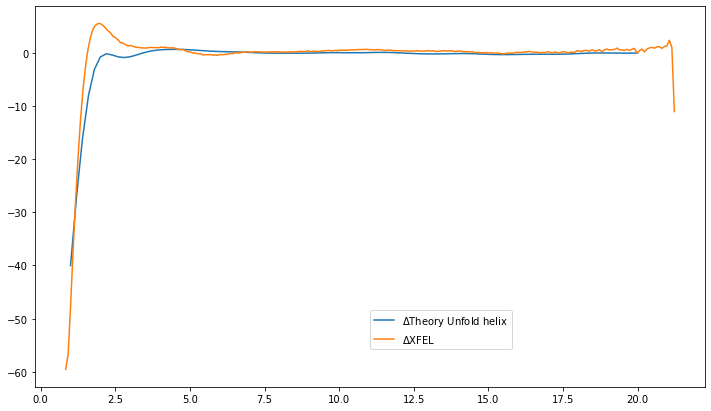

In [1070]:
# Def plot
fig, ax3 = plt.subplots(1, 1, figsize=(12, 7))
theory_diff = I - I_dark

h1_af2 = h1[10:255]
h1_q = hamburg_q[10:255]
q_max,q_min = (h1_q[-1],h1_q[0])
#Decide what q-range
theory_q,crysol_i = cut_q(q,q_max,q_min)
theory_diff = theory_diff[crysol_i]


xfel_q,xfel_i = cut_q(h1_q,q_max,q_min)
xfel_cut = h1_af2[xfel_i]
#interpolate exp diff data
exp_interpolated = interpolate_curve(theory_q,xfel_q,xfel_cut)
exp_scaled_occupancy = exp_interpolated * 1e5
exp_scaled = exp_interpolated*1/theory_q
    
#interpolat exp abs data
dark_abs = np.sum(avg_S_off[150:175,:],axis = 0)/25
dark_abs = (dark_abs - buffer_off*0.905)[10:255]
interpolated_abs = interpolate_curve(theory_q,xfel_q,dark_abs[xfel_i])
# scale theory
theory_scaled = theory_diff * 1/theory_q
# Scale exp. diff and exp. abs to theory (factor of 1*e5 for faster calc.)
scale_diff,fopt_diff = SSE(exp_interpolated * 1e5,theory_diff, 0.0002)
if scale_diff > 0:
    scale_abs,fopt_abs = SSE(interpolated_abs * 1e5, I_dark[crysol_i], 0.0002)
else:
    scale_abs,fopt_abs = SSE(interpolated_abs * 1e5, I[crysol_i], 0.0002)
            
         

            
# Calculate the R2 between intepolated experimental curve and the theoretical curve
r2= calc_r2(exp_interpolated, theory_diff*scale_diff/1e5)
# Calc Pearson CC
corr = np.corrcoef(exp_scaled,theory_scaled, rowvar=True)[0][1]            
# Calc occupance
occupancy = (scale_diff/scale_abs)[0]
            

print(scale_diff)
print(r2)
print(occupancy)
print(corr)


# compare to acutal diff signal both SAXS and XFEL 
#ax3.plot(q_light,differences[-1], label = f'$\Delta$SAXS, 20% excitation, (in scale of $\Delta$XFEL)')
ax3.plot(theory_q,theory_diff*scale_diff, label = f'$\Delta$Theory Unfold helix')
ax3.plot(diff_q,diff_exp * 1e5, label = '$\Delta$XFEL')
ax3.legend(loc=(0.5,0.1), frameon = True,fontsize=10)


# Estimate activation factor - NOV22

## Difference data

In [1467]:
#q range in nm⁻¹
q_range = [hamburg_q[0],diamond_q[-1]*10]

#q_range = [hamburg_q[0],2]

h_indices = hamburg_q<=q_range[1]
hamburg_q_cut = hamburg_q[h_indices]
h1_cut = h1[hamburg_q<=q_range[1]]
diamond_q_cut = diamond_q[np.logical_and(diamond_q >= q_range[0]/10, diamond_q<=q_range[1]/10)]
diff_cut =diff[np.logical_and(diamond_q >= q_range[0]/10, diamond_q<=q_range[1]/10)]
E_diff_cut = E_diff[np.logical_and(diamond_q >= q_range[0]/10, diamond_q<=q_range[1]/10)]
interpolated_h = interpolate_curve(diamond_q_cut*10,hamburg_q_cut,h1_cut)

solution = sse(diff_cut, interpolated_h[0], E_diff_cut)

print(solution[0][0])
1/solution[0][0]
#print(diff.shape)

Optimization terminated successfully.
         Current function value: 1101.788514
         Iterations: 13
         Function evaluations: 26
7.028369140624999


0.14228051771211817

In [1468]:
print('Chi-square minimization for diff data with k=1/10.69 optmized for full q-range:',np.nansum(((interpolated_h[0]-((1/11.07)*diff_cut))/E_diff_cut)**2))
print('Chi-square minimization for diff data with k=1/10.69 optmized for full qmax=3:',np.nansum(((interpolated_h[0]-((1/10.69)*diff_cut))/E_diff_cut)**2))
print('Chi-square minimization for diff data with k=1/10.69 optmized for full qmax2.5:',np.nansum(((interpolated_h[0]-((1/10.23)*diff_cut))/E_diff_cut)**2))
print('Chi-square minimization for diff data with k=1/10.69 optmized for full qmax=2:',np.nansum(((interpolated_h[0]-((1/9.817)*diff_cut))/E_diff_cut)**2))

#print('Least square for diff data with k=1/10.24 optimized with qmax = 2.5 nm⁻¹',np.nansum(())**2)))
#print('Least square for diff data with k=1/9.826 optimized with qmax = 2.0 nm⁻¹',np.nansum((interpolated_h[0]-(1/cut_25)*diff_cut)/(np.std(interpolated_h[0])*E20_cut))**2)
#print('Least square for diff data with k=1/10.24 optimized with qmax = 2.5 nm⁻¹',np.nansum(())**2))
#print('Least square for diff data with k=1/10.71 optimized with qmax = 3.0 nm⁻¹',np.nansum((interpolated_h_dark[0]-(1/cut_3*diff))**2))
#print('Least square for diff data with k=1/11.08 optimized with full q-range (qmax ~3.4 nm⁻¹)',np.nansum((interpolated_h_dark[0]-(1/12*diff))**2))

Chi-square minimization for diff data with k=1/10.69 optmized for full q-range: 14.163375418287108
Chi-square minimization for diff data with k=1/10.69 optmized for full qmax=3: 14.194219176238928
Chi-square minimization for diff data with k=1/10.69 optmized for full qmax2.5: 14.32880471685864
Chi-square minimization for diff data with k=1/10.69 optmized for full qmax=2: 14.563652025335784


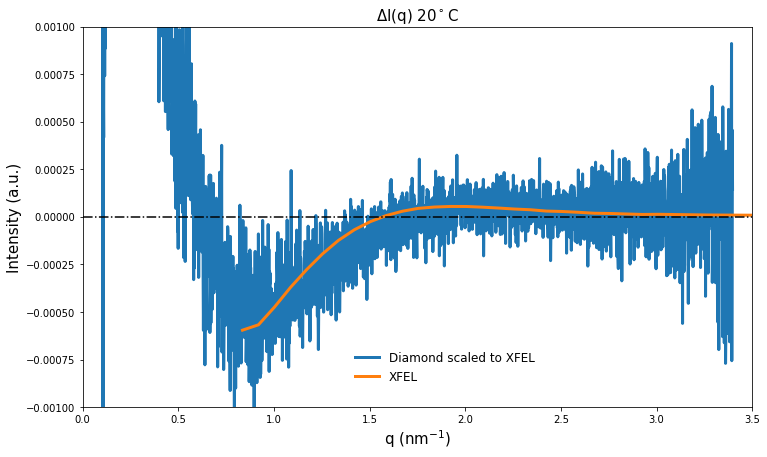

In [1483]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(diamond_q*10,diff*(1/solution[0][0]),linewidth=3.0, label='Diamond scaled to XFEL')
#ax.plot(diamond_q*10,diff*(1/10.23),linewidth=3.0, label='Diamond scaled to XFEL qmax=2.5nm$^{-1}$')
#ax.plot(diamond_q*10,diff*(1/10.69),linewidth=3.0, label='Diamond scaled to XFEL qmax=3.0nm$^{-1}$')
#ax.plot(diamond_q*10,diff_cut*(1/solution[0][0]),linewidth=3.0, label='Diamond scaled to XFEL full q-range')
ax.plot(hamburg_q,h1,linewidth=3.0, label='XFEL')
ax.set_title(r'$\Delta$I(q) 20$^\circ$C',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_ylim([-.001,.001])
ax.set_xlim([0,3.5])
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.legend(loc=(0.4,0.05), frameon = False,fontsize=12)
ax.hlines(0, xmin = q[0], xmax = hamburg_q[-1], color='k', linestyle='-.')
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Diff_curve_comparison_310123',bbox_inches='tight',facecolor=(1, 1, 1))

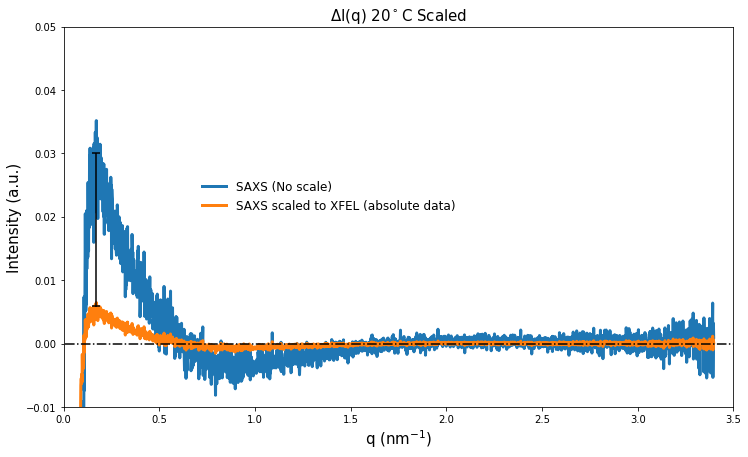

In [1669]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

#SAXS
ax.set_ylim([-.01,.05])
ax.plot(diamond_q*10,diff_cut,linewidth=3.0, label='SAXS (No scale)')
ax.plot(diamond_q*10,diff_cut*(1/(5.42)),linewidth=3.0, label='SAXS scaled to XFEL (absolute data)')
#ax.plot(diamond_q*10,diff_cut*(1/(5.42)*5.42*1.28),linewidth=3.0, label='SAXS scaled to XFEL (absolute data)')
#ax.plot(hamburg_q,h1*(9.817),linewidth=3.0, label='XFEL scaled to Diamond qmax=2nm$^{-1}$')
#ax.plot(hamburg_q,h1*(10.23),linewidth=3.0, label='XFEL scaled to Diamond qmax=2.5nm$^{-1}$')
#ax.plot(hamburg_q,h1*(10.69),linewidth=3.0, label='XFEL scaled to Diamond qmax=3.0nm$^{-1}$')


#XFEL
#ax.set_ylim([-.00004,.0006])
#ax.plot(hamburg_q,h1,linewidth=3.0, label='XFEL no scale')
#ax.plot(hamburg_q,h1*5.42,linewidth=3.0, label='XFEL scaled to Diamond ')

ax.set_title(r'$\Delta$I(q) 20$^\circ$C Scaled',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)

ax.hlines(0.03, xmin = 0.15, xmax = 0.19, color='black', linestyle='-')
ax.hlines(0.006, xmin = 0.15, xmax = 0.19, color='black', linestyle='-')

ax.vlines(0.17, ymin = 0.0058, ymax = 0.03, color='black', linestyle='-')


ax.set_xlim([0,3.5])
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.legend(loc=(0.2,0.5), frameon = False,fontsize=12)
ax.hlines(0, xmin = q[0], xmax = hamburg_q[-1], color='k', linestyle='-.')
#plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Diff_curve_scaled_ratio',bbox_inches='tight',facecolor=(1, 1, 1))

In [1655]:
no_scale = .03
scale = np.nanmax(diff_cut/5.42)

1/0.78
ratio=(no_scale-scale)/no_scale

print(1/ratio)
print(5.42/ratio)



1.2760247043405246
6.916053897525643


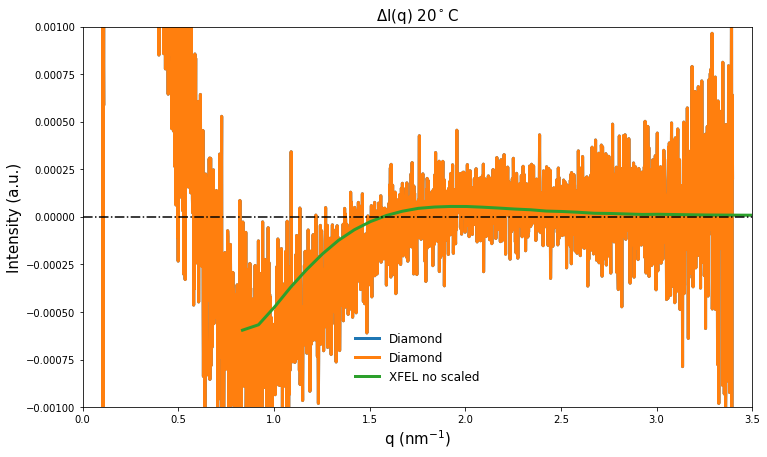

In [1553]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

diff_htest = light_h-dark_h


ax.plot(diamond_q*10,diff_cut*(1/5),linewidth=3.0, label='Diamond')

ax.plot(diamond_q*10,diff_cut*(1/5),linewidth=3.0, label='Diamond')

ax.plot(hamburg_q,h1,linewidth=3.0, label='XFEL no scaled')



ax.set_title(r'$\Delta$I(q) 20$^\circ$C',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_ylim([-.001,.001])
ax.set_xlim([0,3.5])
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.legend(loc=(0.4,0.05), frameon = False,fontsize=12)
ax.hlines(0, xmin = q[0], xmax = hamburg_q[-1], color='k', linestyle='-.')
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Diff_curve_comparison_reverse_310123',bbox_inches='tight',facecolor=(1, 1, 1))




## Absolute data

### Dark

In [295]:
dark_h = np.sum(avg_S_off[150:175,:],axis = 0)/25
dark_h = (dark_h - buffer_off*0.935)[10:255]
interpolated_h_dark = interpolate_curve(diamond_q*10,hamburg_q[10:255],dark_h)
solution_dark = SSE(dark_I1,interpolated_h_dark[0])
print(solution_dark[0][0])
1/solution_dark[0][0]

4.266015625000014


0.23441076824466547

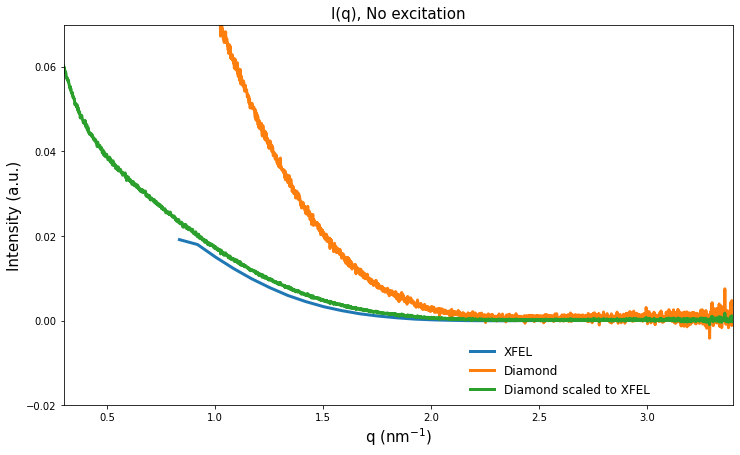

In [296]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q[10:255], dark_h,linewidth=3.0, label='XFEL')
ax.plot(diamond_q*10, dark_I1,linewidth=3.0, label='Diamond')

ax.plot(diamond_q*10, dark_I1*1/solution_dark[0][0],linewidth=3.0, label='Diamond scaled to XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q), No excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/No_excitation_310123',bbox_inches='tight',facecolor=(1, 1, 1))

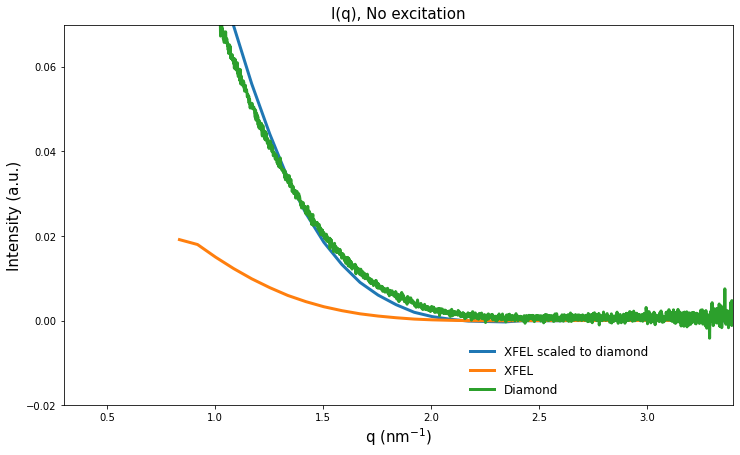

In [2176]:
#Plot the dark data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q,(dark_h)*(5.67),linewidth=3.0, label='XFEL scaled to diamond')
ax.plot(hamburg_q,(dark_h),linewidth=3.0, label='XFEL ')
ax.plot(diamond_q*10, dark_I1,linewidth=3.0, label='Diamond')




ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q), No excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/No_excitation_reverse_310123_old',bbox_inches='tight',facecolor=(1, 1, 1))

In [2164]:
from fractions import Fraction
activation_factor=solution_dark[0][0]/solution[0][0]
print(activation_factor)
print(1/activation_factor)


NameError: name 'solution' is not defined

### Light

In [2177]:
light_h=np.sum(avg_S_on[150:175,:],axis = 0)/25
light_h = light_h - buffer_on*0.935
interpolated_h_light = interpolate_curve(diamond_q*10,hamburg_q,light_h)
solution_light = sse(light_I1,interpolated_h_light[0], E_light)
print(solution_light[0][0])
print(1/solution_light[0][0])

Optimization terminated successfully.
         Current function value: 5165.846266
         Iterations: 18
         Function evaluations: 36
5.025524902343747
0.19898418959850966


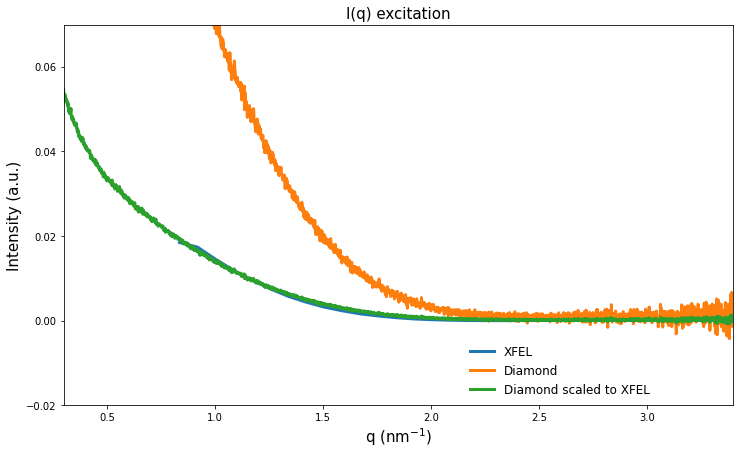

In [2178]:
#Plot the light data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q, light_h,linewidth=3.0, label='XFEL')
ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond')
ax.plot(diamond_q*10, light_I1*1/solution_light[0][0],linewidth=3.0, label='Diamond scaled to XFEL')


ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q) excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/excitation',bbox_inches='tight',facecolor=(1, 1, 1))

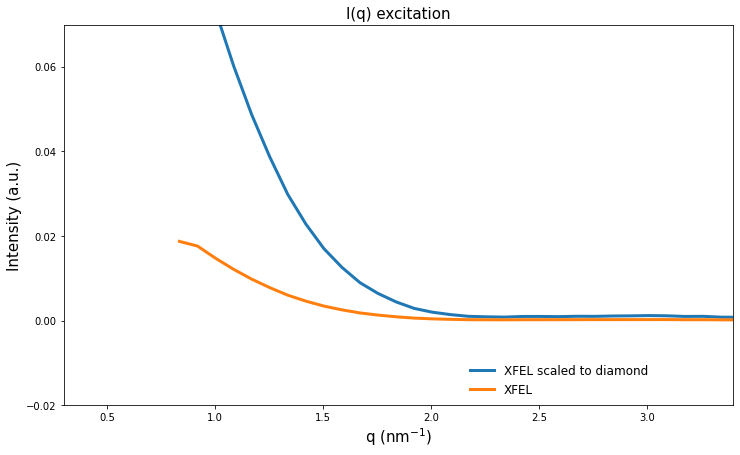

In [2153]:
#Plot the light data from XFEL averaged over runs [172,174,175,1756,180], only dark corresponding to last timepoints taken. 

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(hamburg_q,(light_h)*solution_dark[0][0],linewidth=3.0, label='XFEL scaled to diamond')
ax.plot(hamburg_q,(light_h),linewidth=3.0, label='XFEL')
#ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond')




ax.legend(loc=(0.6,0.01), frameon = False,fontsize=12)
ax.set_title(r'I(q) excitation',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)
ax.set_ylim([-.02,.07])
ax.set_xlim([0.3,3.4])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/No_excitation',bbox_inches='tight',facecolor=(1, 1, 1))

### Light and Dark


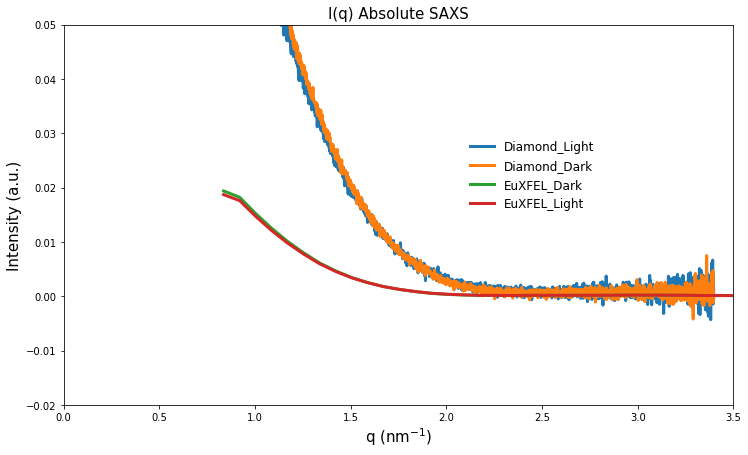

In [2152]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
#solution = sse(light_I1, dark_I1, E_diff)
#print(solution[0][0])

ax.plot(diamond_q*10, light_I1,linewidth=3.0, label='Diamond_Light')
ax.plot(diamond_q*10, dark_I1,linewidth=3.0, label='Diamond_Dark')


ax.plot(hamburg_q, dark_h,linewidth=3.0, label='EuXFEL_Dark')
ax.plot(hamburg_q, light_h,linewidth=3.0, label='EuXFEL_Light')

#ax.plot(diamond_q, dark_I1,linewidth=3.0, label='Diamond_Dark_scaled')
ax.legend(loc=(0.6,0.5), frameon = False,fontsize=12)
ax.set_title(r'I(q) Absolute SAXS',fontsize=15)
ax.set_ylabel('Intensity (a.u.)',fontsize=15)
ax.set_xlabel('q (nm$^{-1}$)',fontsize=15)#ax.set_ylim([-.02,.02])
ax.set_xlim([0,3.5])
ax.set_ylim([-.02,.05])
plt.savefig(f'/home/leonardo/SAXS_222711/Plots/Light_Dark_comparison',bbox_inches='tight',facecolor=(1, 1, 1))